<a id='toc'></a>

### Table of contents

* <a href="#eda" style='color:#a52a2a'>Exploratory Data Analysis</a>
* <a href="#mfe" style='color:#a52a2a'>Model Building and Feature Engineering</a>


### Overview and objectives:

 - Create a machine-learning model capable of predicting the burned area in different locations across Zimbabwe over 2014 to 2017.
 - Predictions are the proportion of the burned area per area square, with values of 0 to 1.

### Evaluation:
- Root Mean Squared Error.

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from math import sin, cos, sqrt, atan2, radians
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import lightgbm as lgb

from matplotlib import pyplot as plt, rcParams
import plotly.express as px
import seaborn as sns

rcParams['figure.facecolor'] = 'grey'
rcParams['axes.facecolor'] = 'grey'
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'black'
rcParams['figure.autolayout'] = True
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.grid'] = False

pd.set_option("display.max_columns", 100)

from warnings import simplefilter
simplefilter(action = "ignore", category = pd.errors.PerformanceWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# helper functions (EDA + Modeling)
# all these methods were tried and the
# ones yielding good results were incorporated in the final model

################################## EDA ##################################
def itr_plot(df: pd.DataFrame, cols: list, target: str, kind = 'r', size = None, alpha: float = 0.3,
             fit_reg: bool = True, order: int = 1, lowess: bool = False, line_kws: dict = dict(color = 'r'),
             scatter_kws: dict = dict(alpha =  0.3), hue = None, stat: str = 'count', bins: str = 'auto',
             whis: float = 1.5, n_rows: int = 3, n_cols: int = 4, figsize: tuple = (20, 12), hide_p_bar: bool = False):
    """
    Iterative plotting utilizing seaborn module

    Parameters:
    -----------
    `Kind`: str,
       one of:
        's': scatter
        'r': regression
        'h': histogram
        'b': boxplot
        'v': violinplot
        None lineplot
    """

    fig = plt.figure(figsize = figsize)
    n_rows = n_rows
    n_cols = n_cols

    n = 1
    for col in tqdm(cols, disable = hide_p_bar):
        ax = fig.add_subplot(n_rows, n_cols, n)
        if kind == 's':
            sns.scatterplot(df, x = col, y = target, hue = hue, size = size, alpha = alpha, ax = ax)
        elif kind == 'r':
            sns.regplot(df, x = col, y = target, fit_reg = fit_reg, order = order,
                        lowess = lowess, line_kws = line_kws, scatter_kws = scatter_kws, ci = None, ax = ax)
        elif kind == 'h':
            sns.histplot(df, x = col, hue = hue, stat = stat, bins = bins, ax = ax)
        elif kind == 'b':
            sns.boxplot(df, x = col, hue = hue, whis = whis, ax = ax)
        elif kind == 'v':
            sns.violinplot(df, x = col, hue = hue, ax = ax)
        else:
            sns.lineplot(df, x = col, y = target, hue = hue, ax = ax)

        n+=1
        if len(fig.get_axes()) == n_rows * n_cols:
            n = 1 # reset counter
            plt.show(close = True); # show then close existing figure
            fig = plt.figure(figsize = figsize); # new figure
##################################

def corr_check(cols: list, df: pd.DataFrame, target: str, q: float = .75,
               filter_corr: str = 'pearson', hide_p_bar: bool = False):
    """
    Calculate corr then display results as desired

    Parameters:
    -----------
    q: float,
     quantile to display highly correlated features.
     default is top 25% (> q3) which display correlation
     among a selection of features (quant) that has high correlation with
     target. i.e: of thoe features that has high correlatin with targe,
     how are they correlated?

    filter_corr: str,
     correlation to filter and sort data
    """
    corr = [] # result container

    for col in tqdm(cols, desc = f'Calculating Corr....', disable = hide_p_bar):
        r_pea, p_pea = stats.pearsonr(df[target], df[col])
        r_spr, p_spr = stats.spearmanr(df[target], df[col])
        corr.append((col, r_pea, p_pea, r_spr, p_spr))


    # Feature vs Target Correlation Dataframe
    corr_df = pd.DataFrame([c[1:] for c in corr], columns = ['pearson', 'p_val_pear', 'spearman', 'p_val_spr'],
                       index = np.array(corr)[:,:1].ravel()).sort_values(filter_corr, ascending = False)

    # highly correlated features (>= q?)
    feat_corr_df = df[corr_df.index[corr_df[filter_corr] >= corr_df[filter_corr].abs().quantile(q)]].corr(filter_corr)

    return corr_df, feat_corr_df
##################################

################################## Feature Engineering ##################################
def date_time(df:pd.DataFrame):
    """
    extract date and time features
    """
    df['Id'] = df.ID.apply(lambda x: x.split('_')[0])
    df['Date'] = df.ID.apply(lambda x: x.split('_')[1])

    # apply correct dtypes
    df['Id'] = df['Id'].astype(int)
    df['Date'] = pd.to_datetime(df['Date'])

    df['day'] = (df.Date.dt.dayofweek).astype(int)
    df['month'] = (df.Date.dt.month).astype(int)
    df['year'] = (df.Date.dt.year).astype(int)
##################################

def change(cols: list, df: pd.DataFrame, overall: bool = True, yoy: bool = False, hide_p_bar: bool = False):
    """
    feature change overtime, either overall or area specific
    """
    for col in tqdm(cols, desc = 'Calculating Change Overtime', disable = hide_p_bar):
        if overall:
            # diff across all areas: same year and month. Example: Jan'01 in all areas
            df[f'{col}_diff'] = df[col].diff().fillna(0)
        else:
            if not yoy:
                df[f'{col}_area_diff'] = df.groupby(['Id'])[col].diff().fillna(0) # diff per area across the year
            else:
                # starting perid is execluded and replaced by 0
                prev_years = df.groupby(['Id'])[col].shift(12)
                df[f'{col}_yoy_diff'] = (df[col] - prev_years).fillna(0) # year on year diff per area: Jan'02 compared to Jan'01
##################################

def group_stats(d: dict, df: pd.DataFrame, hide_p_bar: bool = False):
    """
    calculating statistics of grouped features
    """
    for name, group in tqdm(d.items(), desc = 'Calculating Group Stats', disable = hide_p_bar):
        group_df = df[[g for g in group if g in df]]
        if not group_df.empty:
            df[f"std({name})"] = np.std(group_df, axis = 1)
            df[f"mean({name})"] = np.mean(group_df, axis = 1)
            df[f'sum({name})'] = group_df.sum(axis = 1)
            df[f'prod({name})'] = group_df.prod(axis = 1)
            if len(group) > 2:
                df[f"min({name})"] = np.min(group_df, axis = 1)
                df[f"max({name})"] = np.max(group_df, axis = 1)
                df[f"median({name})"] = np.median(group_df, axis = 1)
##################################

def rolling(cols: list, df:pd.DataFrame, roll_d: dict = None, overall: bool = True, w_z: int = 3,
            w_med: int = 3, w_std: int = 3, w_skw: int = 3, w_kurt: int = 3, w_var: int = 3,
            w_cov: int = 3, w_sem: int = 3, hide_p_bar: bool = False):
    """
    rolling stats, either overall or area specific
    """
    desc = 'Calculating Rolling Stats'

    if roll_d:
        for c in tqdm(cols, desc = desc, disable = hide_p_bar):
            agg = roll_d[c]['agg']
            w = roll_d[c]['w']
            df[f'r_{c}_{agg}'] = df[c].rolling(w).agg([agg]).fillna(0)
    else:
        if overall:
            for c in tqdm(cols, desc = desc, disable = hide_p_bar):
                df[f'r_z_{c}_o'] = ((df[c] - df[c].rolling(w_z).mean()) / df[c].rolling(w_z).std()).fillna(0)
                df[f'r_med_{c}_o'] = df[c].rolling(w_med).median().fillna(0)
                df[f'r_std_{c}_o'] = df[c].rolling(w_std).std().fillna(0)
                df[f'r_skew_{c}_o'] = df[c].rolling(w_skw).skew().fillna(0)
                df[f'r_kurt_{c}_o'] = df[c].rolling(w_kurt).kurt().fillna(0)
                df[f'r_var_{c}_o'] = df[c].rolling(w_var).var().fillna(0)
                df[f'r_cov_{c}_o'] = df[c].rolling(w_cov).cov().fillna(0)
                df[f'r_sem_{c}_o'] = df[c].rolling(w_sem).sem().fillna(0)
        else:
            g = df.groupby(['Id'])
            for c in tqdm(cols, desc = desc, disable = hide_p_bar):
                df[f'r_z_{c}_a'] = ((df[c] - g[c].transform(lambda x: x.rolling(w_z).mean()))
                                    / g[c].transform(lambda x: x.rolling(w_z).std())).fillna(0)
                df[f'r_med_{c}_a'] = g[c].transform(lambda x: x.rolling(w_med).median()).fillna(0)
                df[f'r_std_{c}_a'] = g[c].transform(lambda x: x.rolling(w_std).std()).fillna(0)
                df[f'r_skew_{c}_a'] = g[c].transform(lambda x: x.rolling(w_skw).skew()).fillna(0)
                df[f'r_kurt_{c}_a'] = g[c].transform(lambda x: x.rolling(w_kurt).kurt()).fillna(0)
                df[f'r_var_{c}_a'] = g[c].transform(lambda x: x.rolling(w_var).var()).fillna(0)
                df[f'r_cov_{c}_a'] = g[c].transform(lambda x: x.rolling(w_cov).cov()).fillna(0)
                df[f'r_sem_{c}_a'] = g[c].transform(lambda x: x.rolling(w_sem).sem()).fillna(0)
##################################

def interactions(df: pd.DataFrame):
    """
    feature interaction, these are the ones that provided good results
    """
    df['vpd_div_vap'] = (df['climate_vpd'] / df['climate_vap']).fillna(0)
    df['ele_mul_vs'] = (df['elevation'] * df['climate_vs']).fillna(0)
    df['srad_mul_pet'] = (df['climate_srad'] * df['climate_pet']).fillna(0)
    df['def_div_aet'] = (df['climate_def'] / df['climate_aet']).fillna(0)
    df['def_div_aet'] = np.where(np.isinf(df['def_div_aet']), 0, df['def_div_aet'])
##################################

def land_use(cols: list, df_tr: pd.DataFrame, df_ts: pd.DataFrame, hide_p_bar: bool = False):
    """
    Change year on year with reference to fixed starting period
    """
    ref_idx = df_tr.year.unique()[0]

    for col in tqdm(cols, disable = hide_p_bar):
        # min landcover value at period start for each area
        ref_map = df_tr[df_tr.year == ref_idx].groupby(['Id'])[col].min().to_dict()

        # yoy change
        df_tr[f'landuse_{col[-1]}'] = df_tr[col] - df_tr['Id'].map(ref_map)
        df_ts[f'landuse_{col[-1]}'] = df_ts[col] - df_ts['Id'].map(ref_map)
##################################
def target_encode(cols: list, train_df: pd.DataFrame, test_df: pd.DataFrame, bins: int = 23,
                  agg: str = 'mean', hide_p_bar: bool = False):
    """
    Target encode categorical/discrete variables with optional binning
    """
    for col in tqdm(cols, desc = 'Ongoing Target Encoding...', disable = hide_p_bar):
        # target mean per category
        mask = train_df.groupby([col], as_index = False)['burn_area'].agg(agg)

        # bin encoded values, for high cardinality categorical features
        # choice of bins is random following trial and error,
        # here I used sqrt(533): sqrt(number of areas)
        if mask[col].nunique() > 23:
          mask['bins'] = pd.cut(mask['burn_area'], bins, labels = np.arange(1, bins + 1))
          lab_d = dict(zip(mask[col].values, mask['bins'].values))
        else:
          lab_d = dict(zip(mask[col].values, mask['burn_area'].values))

        # map categories to encoded values
        train_df[f'{col}_tarenc'] = train_df[col].map(lab_d)
        test_df[f'{col}_tarenc'] = test_df[col].map(lab_d)

        test_df[f'{col}_tarenc'].fillna(test_df[f'{col}_tarenc'].mode()[0], inplace = True) # incase of category absence in test set
##################################

def pca_feat(pca_cols: list, train_df: pd.DataFrame, test_df: pd.DataFrame, pca_comp: float = 2, random_state: int = 45):
  """
  Generate PCA features
  """
  scaler = StandardScaler()
  scaler.fit(train_df[pca_cols])

  x_scaled_tr = pd.DataFrame(scaler.transform(train_df[pca_cols]), index = train_df.index, columns = pca_cols)
  x_scaled_ts = pd.DataFrame(scaler.transform(test_df[pca_cols]), index = test_df.index, columns = pca_cols)

  pca = PCA(n_components = pca_comp, random_state = random_state)
  pca.fit(x_scaled_tr)

  pca_data_tr = pca.transform(x_scaled_tr)
  pca_data_ts = pca.transform(x_scaled_ts)

  for i in range(len(pca_data_tr.T)):
    train_df[f'pc_{i+1}'] = pca_data_tr[:, i]
    test_df[f'pc_{i+1}'] = pca_data_ts[:, i]
##################################

def cluster(clus_cols: list, train_df: pd.DataFrame, test_df: pd.DataFrame, clus_comp: int = 23, random_state:int = 45):
  """
  Cluster data
  """
  scaler = StandardScaler()
  scaler.fit(train_df[clus_cols])

  x_scaled_tr = pd.DataFrame(scaler.transform(train_df[clus_cols]), index = train_df.index, columns = clus_cols)
  x_scaled_ts = pd.DataFrame(scaler.transform(test_df[clus_cols]), index = test_df.index, columns = clus_cols)

  # cluster
  model = GaussianMixture(n_components = clus_comp, random_state = random_state)
  model.fit(x_scaled_tr)

  train_df['clusters'] = model.predict(x_scaled_tr)
  test_df['clusters'] = model.predict(x_scaled_ts)
##################################

def dt_cats(cols: list, train_df:pd.DataFrame, test_df:pd.DataFrame, target:pd.Series,
            multi: bool = False, encode: bool = True, rolling: bool = False, q: int = 4,
            hide_p_bar: bool = False):
    """
    Decision trees discretization, single and multiple features
    """
    if multi:

        para_grid = {'max_depth': [3, 6, 12, None]}

        tree = GridSearchCV(DecisionTreeRegressor(random_state=0),
                            cv = 2, scoring = 'neg_root_mean_squared_error',
                            param_grid = para_grid)

        # fit
        tree.fit(train_df[cols], target)

        # set unique column name
        # incase of multiple groups
        # and function calls
        if not rolling:
            name = 'comb'
        else:
            name = 'r_comb'

        n = (train_df.columns.str.contains(name)).astype(int).sum()
        col = f'{name}_{n+1}'

        # predict <- New feature
        train_df[f'{col}_cat'] = tree.predict(train_df[cols])
        test_df[f'{col}_cat'] = tree.predict(test_df[cols])

        if encode:
            # `qcut` divides predictions into intervals that carry the same proportion of observations
            train_df[f'{col}_temp'], bins = pd.qcut(train_df[f'{col}_cat'], q = q, retbins = True, duplicates = 'drop')
            test_df[f'{col}_temp'] = pd.cut(x = test_df[f'{col}_cat'], bins = bins, include_lowest = True)

            # encode
            encoder = OrdinalEncoder(dtype = int, encoded_missing_value = -1).fit(train_df[[f'{col}_temp']])

            # apply encoding
            train_df[f'{col}_disc'] = encoder.transform(train_df[[f'{col}_temp']])
            test_df[f'{col}_disc'] = encoder.transform(test_df[[f'{col}_temp']])

            del train_df[f'{col}_temp'], test_df[f'{col}_temp']

    else:
        para_grid = {'max_depth': [1,3,5]}

        for col in tqdm(cols, desc = 'Ongoing Discretization', disable = hide_p_bar):
            # fit
            dt = GridSearchCV(DecisionTreeRegressor(random_state = 0),
                              cv = 2,
                              scoring = 'neg_root_mean_squared_error',
                              param_grid = para_grid)

            dt.fit(train_df[[col]], target)

            # predict <- New feature
            train_df[f'{col}_cat'] = dt.predict(train_df[[col]])
            test_df[f'{col}_cat'] = dt.predict(test_df[[col]])

            if encode:
                # divides predictions into intervals that carry the same proportion of observations
                train_df[f'{col}_temp'], bins = pd.qcut(train_df[f'{col}_cat'], q = q, retbins = True, duplicates = 'drop')
                test_df[f'{col}_temp'] = pd.cut(x = test_df[f'{col}_cat'], bins = bins, include_lowest = True)

                # encode
                encoder = OrdinalEncoder(dtype = int, encoded_missing_value = -1).fit(train_df[[f'{col}_temp']])

                # apply encoding
                train_df[f'{col}_disc'] = encoder.transform(train_df[[f'{col}_temp']])
                test_df[f'{col}_disc'] = encoder.transform(test_df[[f'{col}_temp']])

                del train_df[f'{col}_temp'], test_df[f'{col}_temp']
##################################

class distance:
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame,
                 agg_col: str, cord_d: dict = None, merge: bool = False, hide_p_bar: bool = False):
        """
        find distance(haversine) in miles between two data points
        based on thier lat and long
        """
        self._train_df = train_df
        self._test_df = test_df
        self._agg_col = agg_col
        self._cord_d = cord_d
        self._merge = merge
        self._hide_p_bar = hide_p_bar

    def overall_dist(self) -> pd.DataFrame:
        """
        distance of current area from either
        overall largest burn area or specific coords
        """
        # all area coords
        all_cords = dict(zip(self._train_df['Id'].values, self._train_df[['lon', 'lat']].values))
        # area ID and coords of largest burn area on a yearly basis
        h_burn = self._train_df.loc[self._train_df.groupby(['year'], sort = False)[self._agg_col].idxmax()]

        if not self._cord_d:
            h_cords = dict(zip(h_burn['Id'].values, h_burn[['lon', 'lat']].values))
        elif self._merge and self._cord_d:
            h_cords = self._cord_d | dict(zip(h_burn['Id'].values, h_burn[['lon', 'lat']].values))
        else:
            h_cords = self._cord_d

        # distance between selected coords
        dist_ = self._dis_dict(all_cords, h_cords)

        # distance mapping to each area
        for area_h, cords_h in tqdm(h_cords.items(), desc = 'Mapping Distance', disable = self._hide_p_bar):
            self._train_df[f'dist_{area_h}'] = self._train_df.Id.map(pd.DataFrame(
                dist_, index = all_cords.keys())[area_h].to_dict()).astype(int)
            self._test_df[f'dist_{area_h}'] = self._test_df.Id.map(
                pd.DataFrame(dist_, index = all_cords.keys())[area_h].to_dict()).astype(int)

        return self._train_df, self._test_df

    def area_dist(self, adj: bool = False) -> pd.DataFrame:
        """
        pairwise distance from highest and lowest
        burn area within specific lat and long and/or adjacent
        lat and long
        """
        la_ = self._train_df.lat.astype(int).unique()
        lo_ = self._train_df.lon.astype(int).unique()

        # area within each grid
        masks = [self._train_df[(self._train_df.lat > lat) & (self._train_df.lat < lat + 1) &
                                (self._train_df.lon > lon) & (self._train_df.lon < lon + 1)] \
                 for lat in la_ for lon in lo_]

        for i, mask in tqdm(enumerate(masks), desc = 'Mapping Distance', disable = self._hide_p_bar ):
            if len(mask) != 0:
                # all area coords
                all_cords = dict(zip(mask['Id'].values, mask[['lon', 'lat']].values))

                # highest and lowest burn area cords at current segment
                max_ = mask[self._agg_col].max()
                min_ = mask[mask[self._agg_col] > 0][self._agg_col].min()
                hi_lo = mask[(mask[self._agg_col] == max_) | (mask[self._agg_col] == min_)]
                hi_lo_d = dict(zip(hi_lo['Id'].values, hi_lo[['lon', 'lat']].values))

                if adj: # check adjacent segment
                  adj_seg = next(iter(masks[i:]))
                  if len(adj_seg) != 0:
                    # highest and lowest burn area cords at adjacent segment
                    max_adj = adj_seg[self._agg_col].max()
                    min_adj = adj_seg[adj_seg[self._agg_col] > 0][self._agg_col].min()
                    hi_lo_adj = adj_seg[(adj_seg[self._agg_col] == max_) | (adj_seg[self._agg_col] == min_)]
                    hi_lo_adj_d = dict(zip(hi_lo_adj['Id'].values, hi_lo_adj[['lon', 'lat']].values))

                    # merge two dicts
                    hi_lo_d = hi_lo_d | hi_lo_adj_d

                if self._merge and self._cord_d:
                    h_cords = self._cord_d | hi_lo_d
                else:
                    h_cords = hi_lo_d

                # distance between selected coords
                dist_ = self._dis_dict(all_cords, h_cords)

                ids = mask.Id.unique()

                for area_h, cords_h in h_cords.items():
                    self._train_df.loc[self._train_df.Id.isin(ids), f'dist_{area_h}'] = self._train_df.loc[self._train_df.Id.isin(ids)].Id.map(
                      pd.DataFrame(dist_, index = all_cords.keys())[area_h].to_dict()).astype(int)
                    self._test_df.loc[self._test_df.Id.isin(ids), f'dist_{area_h}'] = self._test_df.loc[self._test_df.Id.isin(ids)].Id.map(
                      pd.DataFrame(dist_, index = all_cords.keys())[area_h].to_dict()).astype(int)

        self._train_df = self._train_df.fillna(0)
        self._test_df = self._test_df.fillna(0)

        return self._train_df, self._test_df

    def _dis_dict(self, all_cords: dict, h_cords: dict) -> dict:
        """
        Given pair of coords dicts, return distance betwen each
        """
        dist_ = {}
        for area_a, cords_a in all_cords.items():
            for area_h, cords_h in h_cords.items():
                dist_.setdefault(area_h, []).append(self._haversine(cords_a, cords_h))

        return dist_

    def _haversine(self, c_1: tuple, c_2: tuple) -> float:
        """
        parameters:
        ------------
        c_1, c_1: tuple of long and lat, order matters

        Returns:
        --------
        distance based on Haversine formula
        """
        # unpack coords
        lon_1, lat_1 = c_1[0], c_1[1]
        lon_2, lat_2 = c_2[0], c_2[1]

        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon_1, lat_1, lon_2, lat_2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        R = 6371.0 # -----> Approximate radius of earth in km (International Union of Geodesy and Geophysics)

        distance = R * c

        return distance * 0.621371192 # convert to miles
##################################

def winso(train_df: pd.DataFrame, test_df: pd.DataFrame, cols: list,
          method: str = 'iqr', tail: str = 'both', hide_p_bar: bool = False):
    """
    Identify and handle outlier values, focusing on individual features one at a time.

    Identification is done by calculating a threshold beyond which an observation is
    considered to be an outlier, using one of the following methods:
        - 'gaus': Gaussian approximation, outliers are captured based on distance from
            the mean. Example: x data point is an outlier if:
            (mean - 3 * std) > x > (mean + 3 * std) where 3 is distance from mean.
        - 'iqr': Inter-quantile range proximity rule (IQR), outliers are identified based on
            distance from IQR(Q3-Q1). Example: x data point is an outlier if:
            (q1 - 1.5 * iqr) > x > (q3 + 1.5 * iqr) where 1.5 is distance from IQR.
        - 'mad': Median Absoulte Deviation from the median (MAD-median rule), same formula
            as Gaussian approximation, however, replacing mean with median and std
            with MAD which is suitable for skewed data
        - 'q': Quantiles: outliers are identified using a specific quantile values.
            Example: x data point is an outlier if: (.05) > x > (1-.05) where .05 and
            1-.05 is the 5th and 95th quantile.
    tail: str,
        specify direction to label outliers One of 'both', 'right', 'left'.
        If 'both' outliers are both ends of the distribution are highlighted,
        If 'right' outliers at the right end of the distribution are highlighted,
        If 'left' outliers at the left end of the distribution are highlighted.
    """
    # default distance to label outliers
    param_dict = {'gaus': 3, 'iqr': 1.5, 'mad': 3, 'q': .05}

    olrs = {}

    for col in tqdm(cols, desc = f'Spotting and Capping Outliers....', disable = hide_p_bar):

        if method == 'gaus':
            dist = param_dict[method]
            # find boundaries
            # ddof = 0 divides by N instead of N-1
            col_mean, col_std = train_df[col].mean(), train_df[col].std(ddof = 0)
            thresh_min = col_mean - (dist * col_std)
            thresh_max = col_mean + (dist * col_std)

        elif method == 'iqr':
            dist = param_dict[method]
            # find boundaries
            q1, q3 = train_df[col].quantile(0.25), train_df[col].quantile(0.75)
            thresh_min = q1 - dist * (q3 - q1)
            thresh_max = q3 + dist * (q3 - q1)

        elif method == 'mad':
            dist = param_dict[method]
            # find boundaries
            col_median = train_df[col].median()
            mad = (train_df[col] - col_median).abs().median() / 0.67449 # scaling factor for normal distribution

            thresh_min = col_median - (dist * mad)
            thresh_max = col_median + (dist * mad)

        elif method == 'q':
            dist = param_dict[method]
            # find boundaries
            thresh_min, thresh_max = train_df[col].quantile(dist), train_df[col].quantile(1 - dist)

        # capture outliers' index
        if tail == 'both':
            olrs_idx_tr = train_df[(train_df[col] < thresh_min) |
                                   (train_df[col] > thresh_max)].index
            olrs_idx_ts = test_df[(test_df[col] < thresh_min) |
                                  (test_df[col] > thresh_max)].index

            # winsorize
            train_df[f'{col}_winso'] = np.where(train_df[col] > thresh_max, thresh_max,
                                                np.where(train_df[col] < thresh_min, thresh_min, train_df[col]))
            test_df[f'{col}_winso'] = np.where(test_df[col] > thresh_max, thresh_max,
                                               np.where(test_df[col] < thresh_min, thresh_min, test_df[col]))

        elif tail == 'right':
            olrs_idx_tr = train_df[(train_df[col] > thresh_max)].index
            olrs_idx_ts = test_df[(test_df[col] > thresh_max)].index

            # winsorize
            train_df[f'{col}_winso'] = np.where(train_df[col] > thresh_max, thresh_max, train_df[col])
            test_df[f'{col}_winso'] = np.where(test_df[col] > thresh_max, thresh_max, test_df[col])
        else:
            olrs_idx_tr = train_df[(train_df[col] < thresh_min)].index
            olrs_idx_ts = test_df[(test_df[col] < thresh_min)].index

            # winsorize
            train_df[f'{col}_winso'] = np.where(train_df[col] < thresh_min, thresh_min, train_df[col])
            test_df[f'{col}_winso'] = np.where(test_df[col] < thresh_min, thresh_min, test_df[col])

        # update index container
        olrs[col] = {'train': olrs_idx_tr, 'test': olrs_idx_ts}

    return olrs
##################################

################################## Modeling ##################################
# this is the nucleus of this notebook
# looping through various combinations of features, models and params

def cross_val(tr_df: pd.DataFrame, ts_df: pd.DataFrame, fit_cols: list, target: str, cv: dict, fe: bool = False,
              voting: bool = False, change_cols: list = None, grouping_cols: dict = None, landuse_cols: list = None,
              rolling_cols: list = None, te_cols: list = None, dt_cats_cols: list = None, winso_cols: list = None,
              agg_feat: str = 'burn_area', overall_dist: bool = False, dist_d: dict = None, dist_merge = False,
              dist_adj: bool = False, winso_method = 'gaus', winso_tail = 'both', change_overall: bool = True,
              change_yoy: bool = False, roll_d: dict = None, rolling_overall: bool = True, r_w_z: int = 3,
              r_w_med: int = 3, r_w_std: int = 3, r_w_skw: int = 3, r_w_kurt: int = 3, r_w_var: int = 3,
              r_w_cov: int = 3, r_w_sem: int = 3, te_bins: int = 23, te_agg: str = 'mean',
              dt_multi: bool = False, dt_encode: bool = True, dt_rolling: bool = False,
              dt_q: int = 4, sub = False, random_state = 45):

    """
    Progressive validation, feature engineering and model evaluation
    """
    score = {}

    for fold, year in tqdm(cv.items(), desc = 'Ongoing Validation.....'):
        train_df = tr_df[tr_df.year < year].copy()
        test_df = ts_df.copy()

        print(f'fold_{fold}: ', f'train_years: {train_df.year.unique()[0]} to {train_df.year.unique()[-1]}',
              f'test_years: {test_df.year.unique()[0]} to {test_df.year.unique()[-1]}')

        if fe:
            # distance
            if overall_dist:
                train_df, test_df = distance(train_df, test_df, agg_feat, dist_d, merge = dist_merge, hide_p_bar = True).overall_dist()
            else:
                train_df, test_df = distance(train_df, test_df, agg_feat, dist_d, merge = dist_merge, hide_p_bar = True).area_dist(adj = dist_adj)

            # feature interaction
            interactions(train_df)
            interactions(test_df)

            # winsorize
            if winso_cols:
                olrs = winso(train_df, test_df, winso_cols, method = winso_method, tail = winso_tail, hide_p_bar = True)

            # change
            if change_cols:
                change(change_cols, train_df, overall = change_overall, yoy = change_yoy, hide_p_bar = True)
                change(change_cols, test_df, overall = change_overall, yoy = change_yoy, hide_p_bar = True)

            # group stats
            if grouping_cols:
                group_stats(grouping_cols, train_df, hide_p_bar = True)
                group_stats(grouping_cols, test_df, hide_p_bar = True)

            # rolling agg
            if rolling_cols:
                rolling(rolling_cols, train_df, overall = rolling_overall, roll_d = roll_d,
                        w_z = r_w_z, w_med = r_w_med, w_std = r_w_std, w_skw = r_w_skw,
                        w_kurt = r_w_kurt, w_var = r_w_var, w_cov = r_w_cov, w_sem = r_w_sem,
                        hide_p_bar = True)
                rolling(rolling_cols, test_df, overall = rolling_overall, roll_d = roll_d,
                        w_z = r_w_z, w_med = r_w_med, w_std = r_w_std, w_skw = r_w_skw,
                        w_kurt = r_w_kurt, w_var = r_w_var, w_cov = r_w_cov, w_sem = r_w_sem,
                        hide_p_bar = True)

            # land use
            if landuse_cols:
                land_use(landuse_cols, train_df, test_df, hide_p_bar = True)

            # Target Encode
            if te_cols:
                target_encode(te_cols, train_df, test_df, bins = te_bins, agg = te_agg,
                              hide_p_bar = True)

            # Bining
            if dt_cats_cols:
                dt_cats(dt_cats_cols, train_df, test_df, train[target],
                        multi = dt_multi, encode = dt_encode, rolling = dt_rolling,
                        q = dt_q, hide_p_bar = True)

            # fit features
            dst = list(train_df.columns[train_df.columns.str.contains('dist_')])
            feat_t = fit_cols + dst + ['Id_tarenc', 'r_climate_srad_std']

        else:
          # fit features
          feat_t = fit_cols

        # scaling
        scaler = StandardScaler()
        if not voting:
            # base model
            model = lgb.LGBMRegressor(verbose = -1, random_state = random_state)

            # pipline
            pl = Pipeline([('Scalar', scaler), ('LGBM', model)])
            pl.fit(train_df[feat_t], np.log1p(train_df[target])) # log1p because target has lots of zero burn area

            # cliped predictions
            preds = pl.predict(test_df[feat_t])
            preds = np.clip(np.expm1(preds), 0, 1)

        else: # hyper params were tuned manually and sequentially, this was faster than waiting for grid search results
            m1 = lgb.LGBMRegressor(n_estimators = 300, learning_rate = .1, random_state = random_state)
            m2 = ExtraTreesRegressor(n_estimators = 40, max_depth = 50, max_features = 'log2', random_state = random_state)
            m3 = KNeighborsRegressor(algorithm = 'brute', weights = 'uniform', n_neighbors = 6)
            m4 = HistGradientBoostingRegressor(max_iter = 450, learning_rate = .1, max_leaf_nodes = 21,
                                               l2_regularization = .05, random_state = random_state)
            esti = ExtraTreeRegressor(max_features = 'sqrt', random_state = random_state)
            m5 = BaggingRegressor(esti, n_estimators = 10, max_features = .6, random_state = random_state)

            # base model
            model = VotingRegressor(estimators=[('lgbm', m1), ('et', m2), ('knn', m3), ('hg', m4), ('bag', m5)],
                                    weights = None, n_jobs = -1)
            # pipline
            pl = Pipeline([('Scalar', scaler), ('Voting Regressor', model)])
            pl.fit(train_df[feat_t], np.log1p(train_df[target]))

            # cliped predictions
            preds = pl.predict(test_df[feat_t])
            preds = np.clip(np.expm1(preds), 0, 1)

        try: # incase of training on full data for submission
            mse = mean_squared_error(test_df[target], preds)
            rmse = np.sqrt(mse)
            r2 = r2_score(test_df[target], preds)

            score[f'f_{fold}'] = {'mse': mse, 'rmse': rmse, 'r2': r2}
        except:
            pass

    if not sub:
        res_df = pd.DataFrame(score)
        res_df['avg'] = np.mean(res_df, axis = 1)

        return res_df, pl, preds # predictions of last fold
    else:
        return pl, preds

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='eda'></a>

## EDA

In [ ]:
# load data
target = 'burn_area'

display(df_tr.head(1), df_tr.shape, df_ts.head(1), df_ts.shape)

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,1692,1861,0,211,317,2493,111,141,413.474762,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.24489,0.009836,0.0,0.256932


(83148, 29)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,1974,0,217,303,2481,99,148,413.474762,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


(25584, 28)

In [ ]:
# check missing
df_tr.isnull().sum().sum(), df_ts.isnull().sum().sum()

(0, 0)

In [ ]:
# check duplicates
display(
    df_tr[df_tr.drop(['burn_area'], axis = 1).duplicated(keep = False)],
    df_ts[df_ts.duplicated(keep = False)]
)

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation


,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation


In [ ]:
# extract time data
date_time(df_tr)
date_time(df_ts)

display(df_tr.year.unique(), df_ts.year.unique())

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013])

array([2014, 2015, 2016, 2017])

In [ ]:
# further data split - 70/30
train = df_tr.loc[df_tr.year < 2011].copy()
valid = df_tr.loc[df_tr.year >= 2011].copy()

# switch to classification
train['bi_tar'] = (train[target] > 0).astype(int)
valid['bi_tar'] = (valid[target] > 0).astype(int)

print(f'Training_data: {train.shape[0]} rows, {train.shape[1]} columns',
      f'Validation_data: {valid.shape[0]} rows, {valid.shape[1]} columns',
      f'Training_size: {round(1 - (valid.shape[0] / train.shape[0]), 2)}',
      f'Training_years: {train.year.unique()[0]} to {train.year.unique()[-1]}',
      f'Validation_years: {valid.year.unique()[0]} to {valid.year.unique()[-1]}',
      f'Positive Burn Area - Training: {train.bi_tar.value_counts(normalize = True)[1].round(3)}',
      f'Positive Burn Area - Validation: {valid.bi_tar.value_counts(normalize = True)[1].round(3)}',
      f'Missing samples: {(train.shape[0] + valid.shape[0]) - df_tr.shape[0]}',
      sep = '\n'
       )

Training_data: 63960 rows, 35 columns
Validation_data: 19188 rows, 35 columns
Training_size: 0.7
Training_years: 2001 to 2010
Validation_years: 2011 to 2013
Positive Burn Area - Training: 0.232
Positive Burn Area - Validation: 0.239
Missing samples: 0


### ETL process:
- Extract:
  - There are 533 area squares each with a unique ID ranging from 0 to 532
  - Training data is aggregated on burned areas across Zimbabwe for each month since 2001 up to the end of 2013, there are 156 record(13 years *  12 months) for 533 areas for a total of ~83k records (156 * 533)
- Transform:
  - No major preprocessing to be perfomed apart from Normalizing features (they have different scale) and transforming target (burn_area) which will be done during modeling to observe the effect of transformation on model performance.
- Load:
  - Data is loaded into the notebook using pandas library


  Notes:
  - No burn area accounts for ~78% of the dataset
  - Training data will be further split into train and validation sets 70-30 for cross validation, final model will be trained on full training data

### Feature meaning

before proceeding with the analysis its important to understand what each feature represents. Given the variable definition data and a bit of research, below are key highlights:

- climate_aet: Actual evapotranspiration, is refers to the combined loss of water from evaporation from soil surfaces (E) and transpiration from plants (T). The destruction of mature forests by fire and the subsequent regrowth of young forests lead to changes in evapotranspiration (ET) and thus discharge and water yield from these forests. (-ve correlation)
- climate_pet: Reference evapotranspiration. is the amount of water that would be evaporated and transpired by a specific crop, soil or ecosystem if there was sufficient water available, is expressed in terms of a depth of water or soil moisture percentage.
- climate_def: Climate water deficit, the amount of water by which potential evapotranspiration (PET) exceeds actual evapotranspiration (AET). (redundant feature: climate_pet - climate_aet)
- climate_pdsi: Palmer Drought Severity Index that generally spans -10 (dry) to +10 (wet), estimates relative soil moisture conditions. The magnitude of PDSI indicates the severity of the departure from normal conditions. A PDSI value >4 represents very wet conditions, while a PDSI <-4 represents an extreme drought. Prolonged drought can limit fire occurrence as the availability of fuels (e.g., grasses) is reduced due to lack of precipitation, its not clear how is it measured in the given data, but in general +ve should be associated with more fire and vise versa. -ve correlation)
- climate_pr: Precipitation accumulation, the sum of precipitation over a certain period of time in a certain place Or: how much rain has fallen or will fall in total. (Higher values could be indication of fires sparked by lightining)
- climate_ro: Runoff, is precipitation that does not soak into the soil but instead moves on the Earth's surface toward streams
- climate_soil: Soil moisture, “the total amount of water, including the water vapor, in an unsaturated soil. The water in land surfaces that is not in rivers, lakes, or groundwater, but instead resides in the pores of the soil
- climate_srad: Downward surface shortwave radiation, solar radiation with a wavelength from 300 to 4000 nm received at the Earth's surface. (meh!)
- climate_swe: Snow water equivalent: determines the amount of water available in the snow. (snow in zimbabwe?)
- climate_vap: Vapor pressure: As the temperature of a liquid or solid increases its vapor pressure also increases
- climate_vpd: Vapor pressure deficit: Vapor pressure deficit can be defined as the amount of vapor that can still be stored in the air until reaching saturation point, under the same temperature. This variable can be calculated as the difference between the actual vapor pressure and the saturation vapor pressure. This can show us how much more room there is in the air for more water vapor. fire consumes vapor leading to higher deficit. (+ve correlation)
- precipitation: Merged microwave/IR precipitation estimate, precipitation is any liquid or frozen water that forms in the atmosphere and falls to Earth. precipitation estimate is a method of approximating the amount of precipitation that has fallen at a location or across a region.

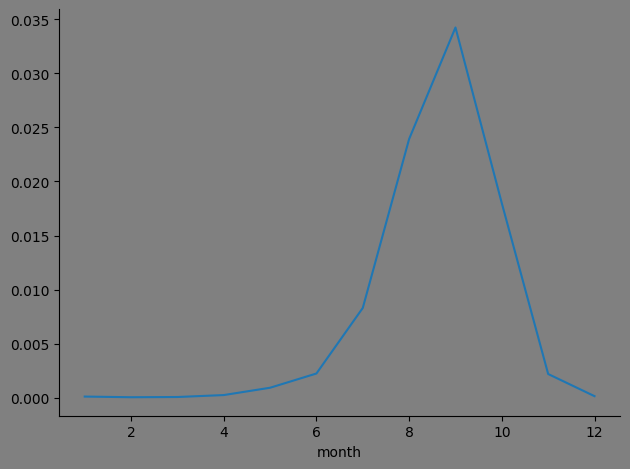

In [ ]:
# burn area - monthly view
train.groupby(['month'])['burn_area'].mean().plot();

Fire outbreaks peaks during summer, this seasonality may be good predictor of burn area and determining rolling window calculation during feature engineering

In [ ]:
# burn area - yearly view
fig = df_tr.groupby('year')['burn_area'].mean().plot(backend = 'plotly', template = 'plotly_dark')
fig.show()

Why 2002 burn area so much lower than the rest?

In [ ]:
# burn area - area view
fig = df_tr[df_tr.year == 2002].groupby(['Id'])['burn_area'].mean().plot(backend = 'plotly', template = 'plotly_dark')

fig.show()

In [ ]:
fig = df_tr[df_tr.year == 2008].groupby(['Id'])['burn_area'].mean().plot(backend = 'plotly', template = 'plotly_dark');
fig.show()

Observations:
- High burn area consistent across the two periods, exmple: area 16 and 20. Using area Id may be a good predictor.
- Almost all areas experienced increased fire occurances with varying magnitude, however thoes that are close(in terms of distance, i.e.: lat and lon) had somewhat similar spikes.
- Area 183 and 213 has gone berserk! Displaying significant increase in burn area.

In [ ]:
# What happened to area 183 from 2002 to 2008
drop_cols = ['ID', 'lat', 'lon', 'Id', 'Date']

mask_2 = df_tr[(df_tr.year == 2002) & (df_tr.Id == 183)]

mask_2.drop(drop_cols, axis = 1).describe().round(2)

,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,day,month,year
count,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.0,12.00,12.00,12.00,12.00,12.00,12.00,12.0,12.0,12.0,12.0,12.00,12.0,12.00,12.0,12.0,12.00,12.00,12.00,12.0
mean,0.01,371.83,1204.08,-255.08,1576.00,38.75,1.92,61.67,2347.83,0.0,161.33,317.58,1574.00,175.17,264.67,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.06,3.00,6.50,2002.0
std,0.02,398.60,459.95,98.99,322.60,41.79,2.02,13.19,257.40,0.0,41.66,26.61,514.94,52.45,46.67,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.06,2.17,3.61,0.0
min,0.00,3.00,477.00,-434.00,1088.00,0.00,0.00,45.00,1859.00,0.0,88.00,267.00,961.00,119.00,197.00,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.00,0.00,1.00,2002.0
25%,0.00,37.25,917.25,-335.00,1390.25,3.75,0.00,51.25,2205.25,0.0,125.50,301.50,1091.25,142.00,232.25,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.01,1.00,3.75,2002.0
50%,0.00,275.50,1257.00,-254.00,1591.00,28.50,1.50,59.50,2359.50,0.0,174.00,321.00,1577.50,158.00,252.00,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.05,3.50,6.50,2002.0
75%,0.00,556.25,1491.50,-170.75,1690.00,58.50,3.00,70.25,2557.00,0.0,191.25,330.25,2048.00,201.25,316.25,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.08,4.25,9.25,2002.0
max,0.06,1133.00,1838.00,-125.00,2222.00,119.00,6.00,86.00,2658.00,0.0,208.00,358.00,2214.00,281.00,341.00,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.19,6.00,12.00,2002.0


In [ ]:
mask_8 = df_tr[(df_tr.year > 2002) & (df_tr.year <= 2008) & (df_tr.Id == 183)]

mask_8.drop(drop_cols, axis = 1).describe().round(2)

,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,day,month,year
count,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.00,72.0,72.00,72.00,72.00,72.00,72.00,72.00,72.0,72.0,72.0,72.0,72.00,72.0,72.00,72.0,72.0,72.00,72.00,72.00,72.00
mean,0.03,463.46,1067.24,-5.19,1530.64,50.75,4.33,192.53,2277.31,0.0,159.78,312.75,1541.26,171.90,263.56,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.08,2.97,6.50,2005.50
std,0.08,500.03,675.69,292.61,356.36,67.58,15.23,252.98,308.60,0.0,43.79,28.91,513.36,55.92,48.63,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.11,1.99,3.48,1.72
min,0.00,1.00,0.00,-397.00,1058.00,0.00,0.00,30.00,1396.00,0.0,77.00,258.00,874.00,101.00,160.00,1028.54,0.0,0.0,0.0,0.0,0.00,0.0,0.99,0.0,0.0,0.00,0.00,1.00,2003.00
25%,0.00,20.25,601.25,-294.50,1286.75,0.00,0.00,53.75,2096.00,0.0,117.00,295.00,1014.00,131.75,232.50,1028.54,0.0,0.0,0.0,0.0,0.00,0.0,0.99,0.0,0.0,0.00,1.00,3.75,2004.00
50%,0.00,152.00,1114.00,-26.50,1416.00,12.00,1.00,90.50,2243.50,0.0,171.50,312.50,1469.50,150.50,251.50,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,0.99,0.0,0.0,0.02,3.00,6.50,2005.50
75%,0.00,878.75,1549.75,270.50,1676.50,81.00,4.00,188.75,2495.25,0.0,197.00,331.25,2105.75,206.50,290.25,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,1.00,0.0,0.0,0.14,5.00,9.25,2007.00
max,0.41,1450.00,2560.00,444.00,2565.00,335.00,127.00,1082.00,3007.00,0.0,219.00,382.00,2308.00,318.00,393.00,1028.54,0.0,0.0,0.0,0.0,0.01,0.0,1.00,0.0,0.0,0.52,6.00,12.00,2008.00


  0%|          | 0/5 [00:00<?, ?it/s]

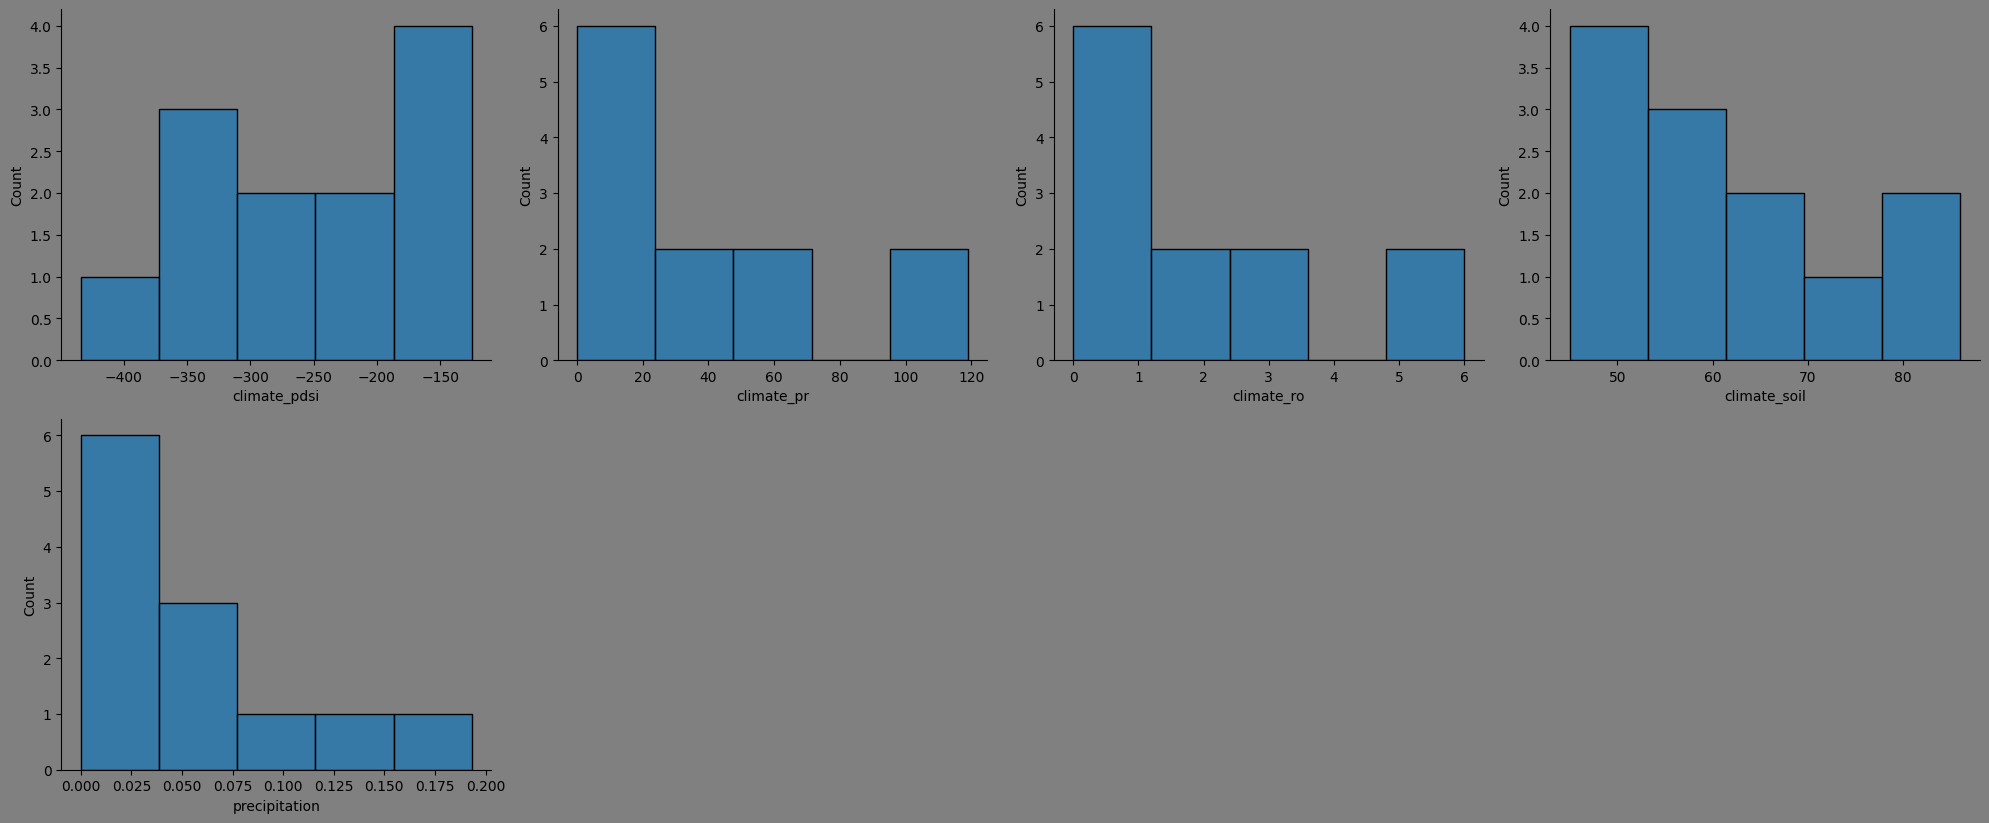

In [ ]:
itr_plot(mask_2, ['climate_pdsi', 'climate_pr', 'climate_ro', 'climate_soil', 'precipitation'], target, kind = 'h')

  0%|          | 0/5 [00:00<?, ?it/s]

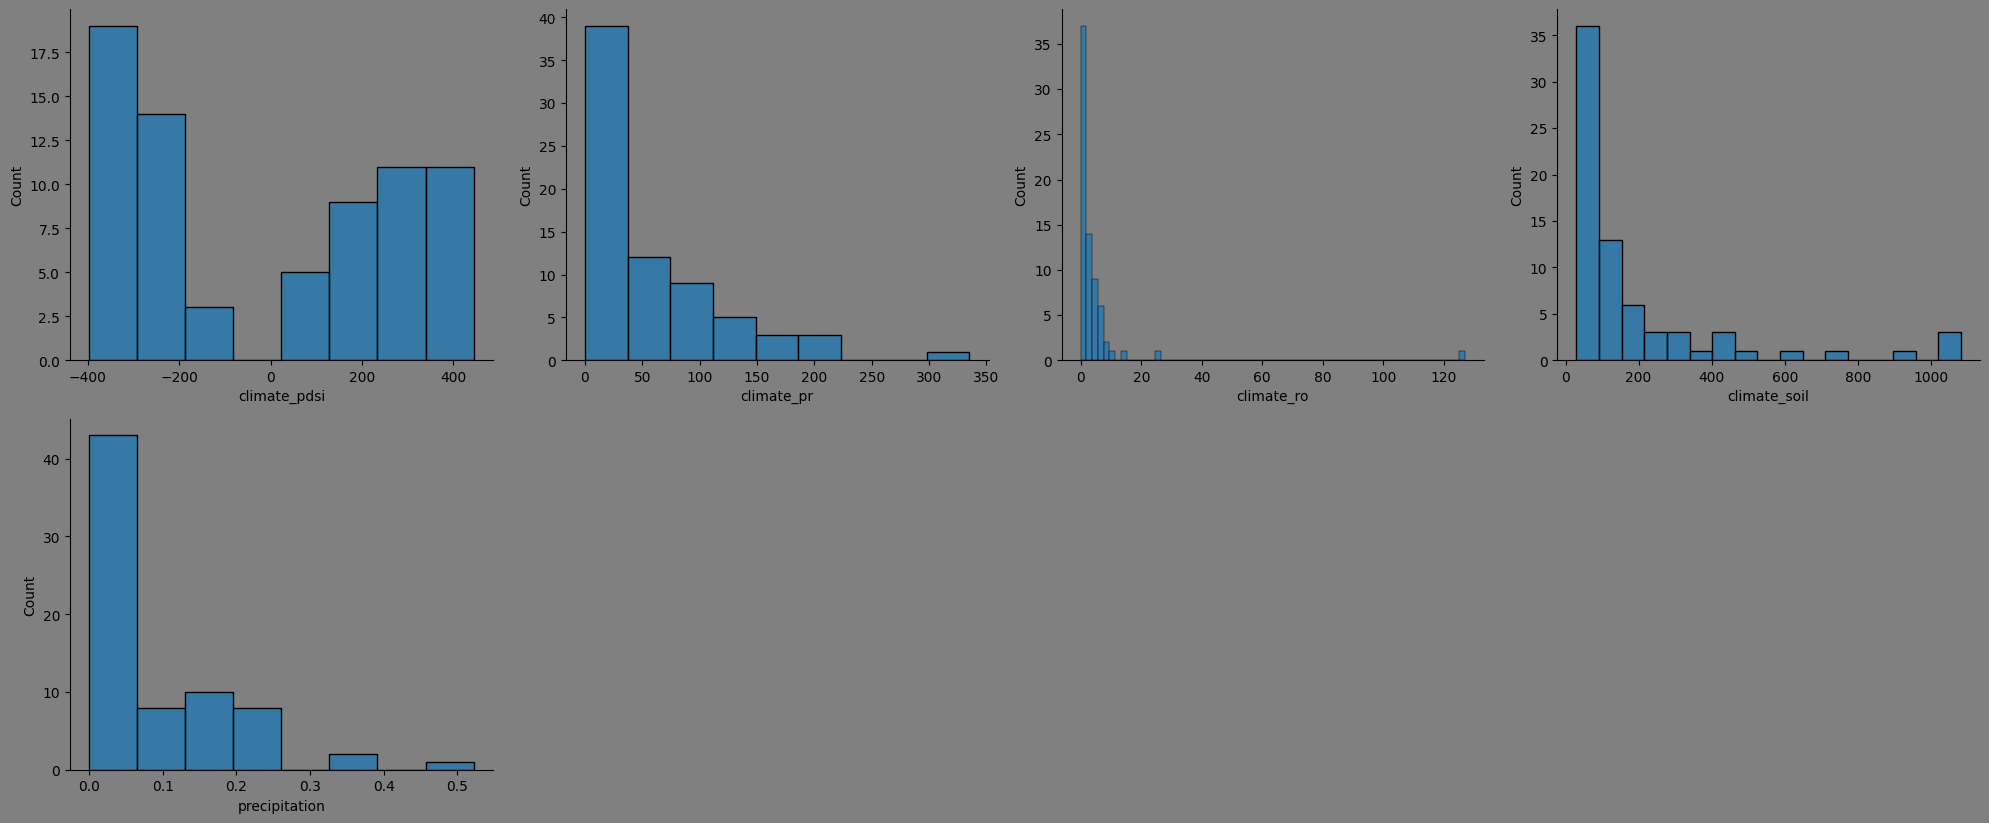

In [ ]:
itr_plot(mask_8, ['climate_pdsi', 'climate_pr', 'climate_ro', 'climate_soil', 'precipitation'], target, kind = 'h')

Observations:
- Whats obvious is the change in water features (percipitation, pr, ro and soil) and pdsi distribution, 2002 had less of the former and more of the latter. This is actually counter intutive as one would expect wet conditions have positive effect on decreasing fire occurance, unless it is the cause of fire (high farming season or outbreaks from lightning during rain). This is reflected in pdsi distribution as -ve means dry soil (less fire fule i.e.: crops) and vise versa.
- Slight change in the composition of land coverage

In [ ]:
# Is landcover of any use
{i:df_tr[df_tr[f'landcover_{i}'] != 0]['burn_area'].mean().round(4) for i in range(9)}

{0: 0.0064,
 1: 0.0063,
 2: 0.0069,
 3: 0.0101,
 4: 0.0077,
 5: 0.0098,
 6: 0.0076,
 7: 0.0047,
 8: 0.009}

Lancover 3 has highest avg burn area among others, followed by landcover 5

In [ ]:
# lancover 3 detailed view
df_tr[df_tr.landcover_3 != 0]

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,Id,Date,day,month,year
77413,128_2013-02-01,-17.858835,25.487029,0.000000,1081,217,187,1299,74,4,922,2385,0,188,309,2143,119,171,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.118481,128,2013-02-01,4,2,2013
77946,128_2013-03-01,-17.858835,25.487029,0.000000,721,844,105,1565,26,1,452,2566,0,183,312,1987,135,230,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.034662,128,2013-03-01,4,3,2013
78479,128_2013-04-01,-17.858835,25.487029,0.000000,168,1282,-168,1450,4,0,319,2370,0,165,319,1596,172,230,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.002511,128,2013-04-01,0,4,2013
79012,128_2013-05-01,-17.858835,25.487029,0.000211,70,1220,-176,1289,0,0,249,2118,0,127,304,1159,176,215,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.000258,128,2013-05-01,2,5,2013
79545,128_2013-06-01,-17.858835,25.487029,0.011097,44,1109,-162,1152,0,0,206,2000,0,104,287,1016,160,233,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.000112,128,2013-06-01,5,6,2013
80078,128_2013-07-01,-17.858835,25.487029,0.027767,30,1242,-147,1272,0,0,175,1997,0,88,283,909,159,265,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.000039,128,2013-07-01,0,7,2013
80611,128_2013-08-01,-17.858835,25.487029,0.032181,22,1504,-131,1527,0,0,153,2200,0,119,313,1019,198,267,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.000174,128,2013-08-01,3,8,2013
81144,128_2013-09-01,-17.858835,25.487029,0.026126,28,1963,-125,1990,1,0,136,2511,0,171,362,1089,292,309,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.003520,128,2013-09-01,6,9,2013
81677,128_2013-10-01,-17.858835,25.487029,0.012295,206,2073,-128,2279,20,1,123,2698,0,205,372,1213,318,318,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.013221,128,2013-10-01,1,10,2013
82210,128_2013-11-01,-17.858835,25.487029,0.001229,715,1002,-64,1716,74,4,111,2321,0,209,352,1749,235,226,990.34971,0.0,0.0,0.001537,0.000307,0.277152,0.000254,0.72075,0.0,0.0,0.089199,128,2013-11-01,4,11,2013


only tied to area 128 in the year 2013!

In [ ]:
# check area
mask_lc3 = df_tr[df_tr.Id == 128]
mask_lc3.groupby('year')['burn_area'].mean()

,burn_area
year,
2001,0.007142
2002,0.004689
2003,0.006434
2004,0.020186
2005,0.008785
2006,0.007451
2007,0.003892
2008,0.010874
2009,0.003571


In [ ]:
# highest burn year
mask_lc3[(mask_lc3.year == 2012)][['burn_area'] + list(mask_lc3.columns[mask_lc3.columns.str.contains('land')])]

,burn_area,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8
70484,0.000000,0.0,0.000000,0.001844,0.0,0.297315,0.000254,0.700587,0.0,0.0
71017,0.000000,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
71550,0.000000,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
72083,0.001844,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
72616,0.012230,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
73149,0.016124,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
73682,0.035069,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
74215,0.493538,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
74748,0.018135,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0
75281,0.000000,0.0,0.000307,0.001537,0.0,0.280881,0.000254,0.717021,0.0,0.0


In [ ]:
# year of highest burn in landcover 3
mask_lc3[(mask_lc3.year == 2013)][['burn_area'] + list(mask_lc3.columns[mask_lc3.columns.str.contains('land')])]

,burn_area,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8
76880,0.000000,0.0,0.000307,0.001537,0.000000,0.280881,0.000254,0.717021,0.0,0.0
77413,0.000000,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
77946,0.000000,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
78479,0.000000,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
79012,0.000211,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
79545,0.011097,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
80078,0.027767,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
80611,0.032181,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
81144,0.026126,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0
81677,0.012295,0.0,0.000000,0.001537,0.000307,0.277152,0.000254,0.720750,0.0,0.0


In [ ]:
mask_lc3.groupby('year')['landcover_3'].max()

,landcover_3
year,
2001,0.000000
2002,0.000000
2003,0.000000
2004,0.000000
2005,0.000000
2006,0.000000
2007,0.000000
2008,0.000000
2009,0.000000


There is a switch from landcover 1 to landcover 3 in 2012 compared to 2013, might not be direct cause of burna area reduction (2012 had single significant incident, idx: 74215) but we can highlight this change in a feature subtracting current year from base year(i.e.: landcover in 2001 - landcover in 2013) and see if it of any use.

In [ ]:
# list all predictors
train.columns

Index(['ID', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'Id', 'Date', 'day', 'month', 'year',
       'bi_tar'],
      dtype='object')

  0%|          | 0/27 [00:00<?, ?it/s]

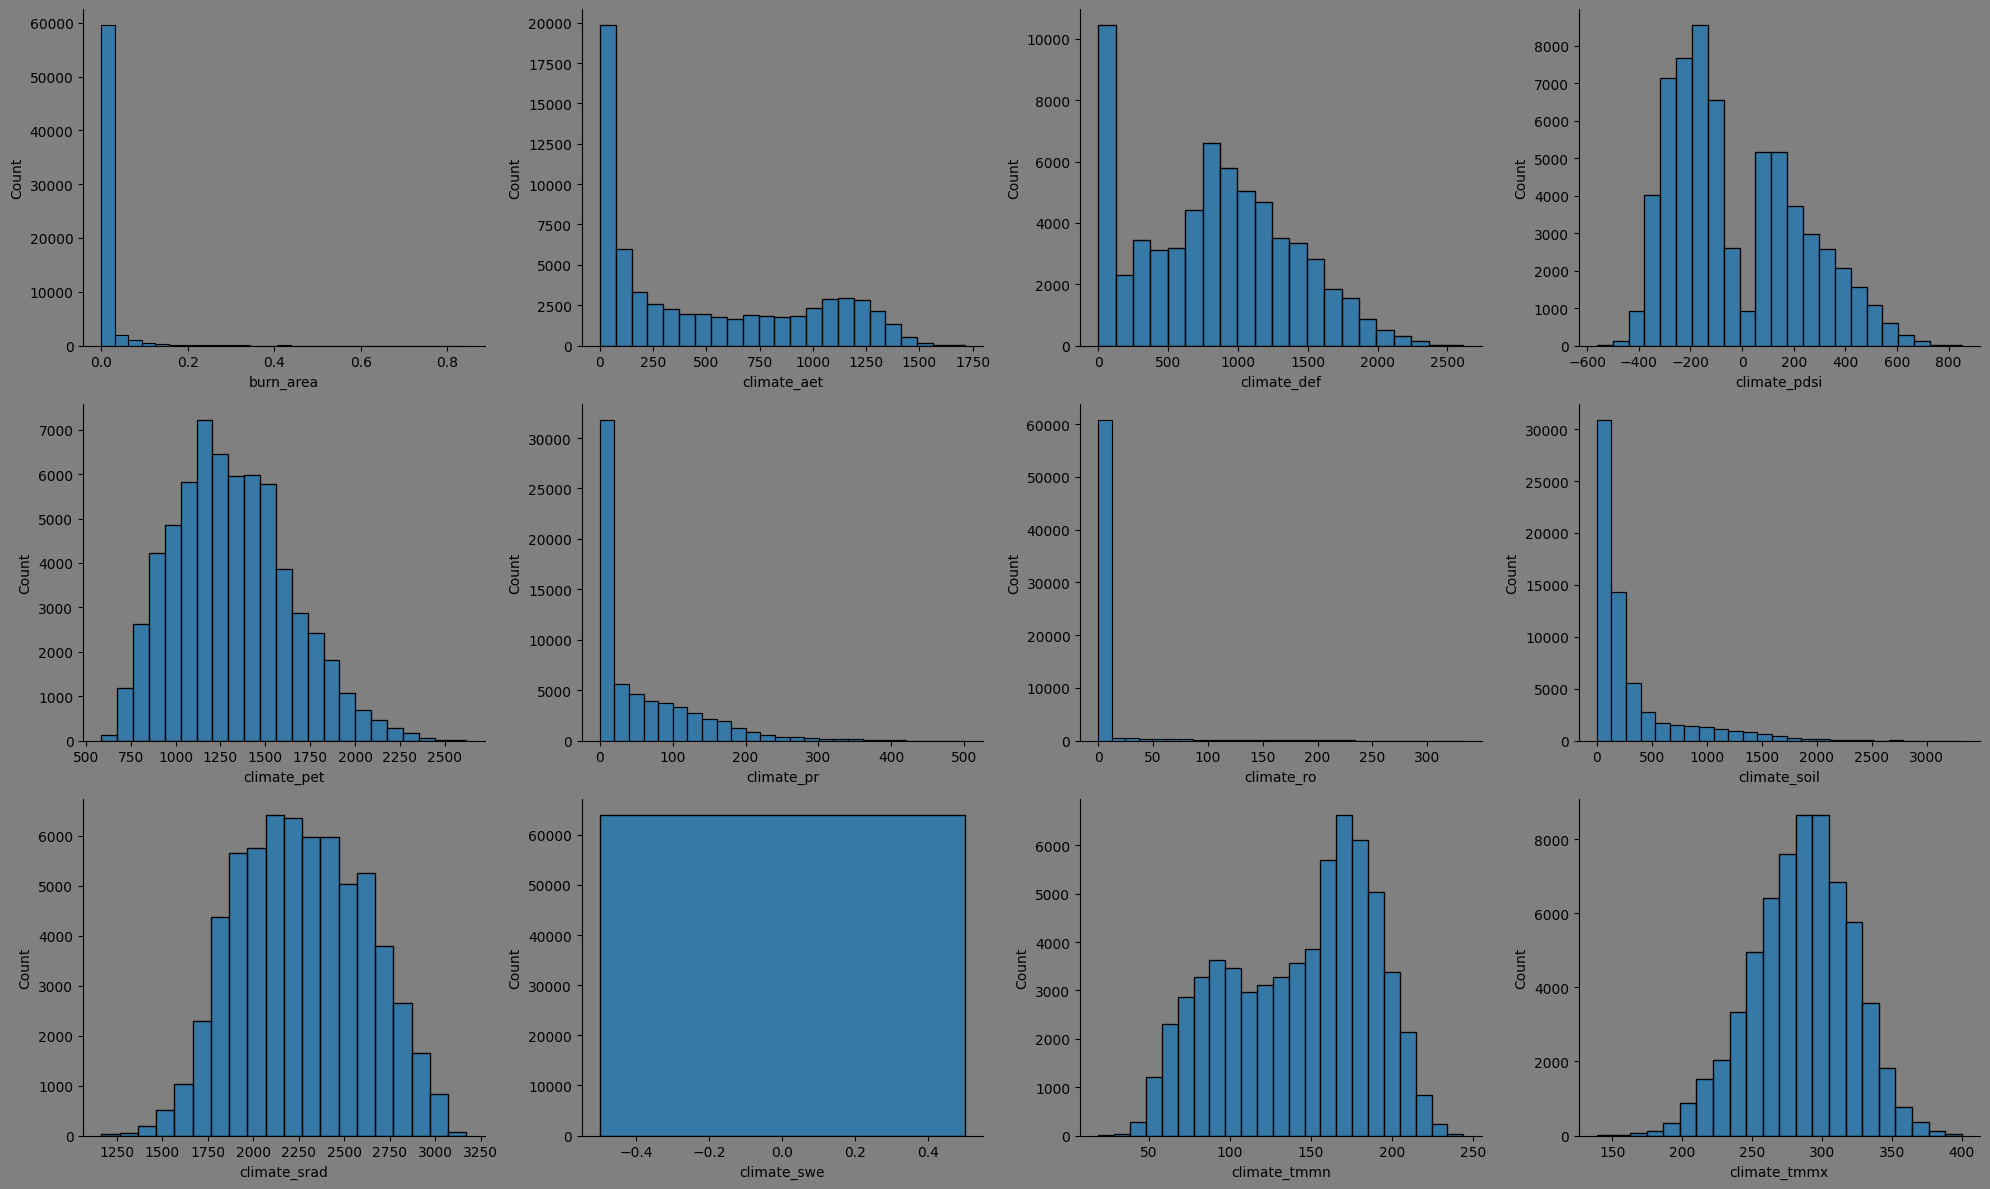

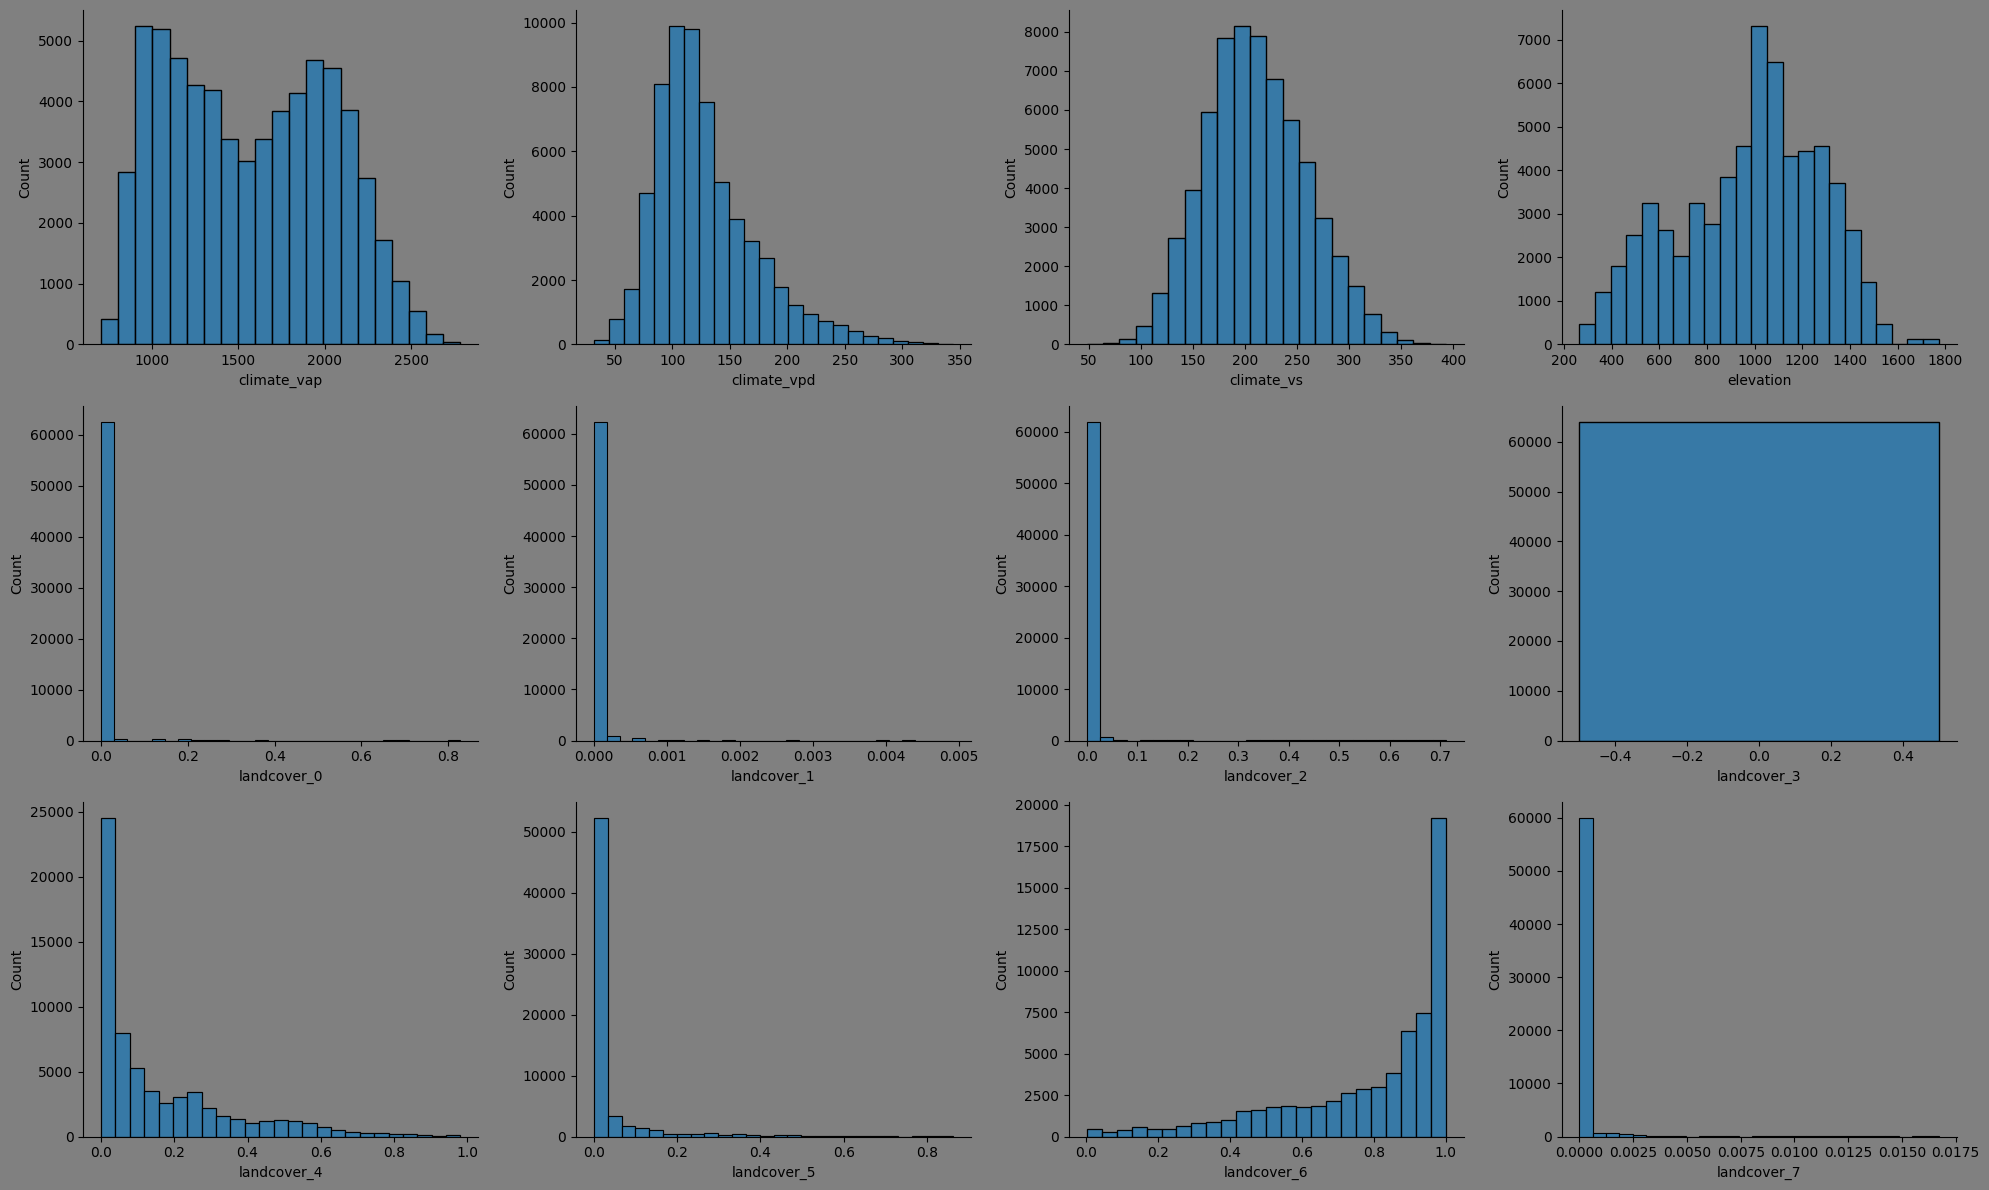

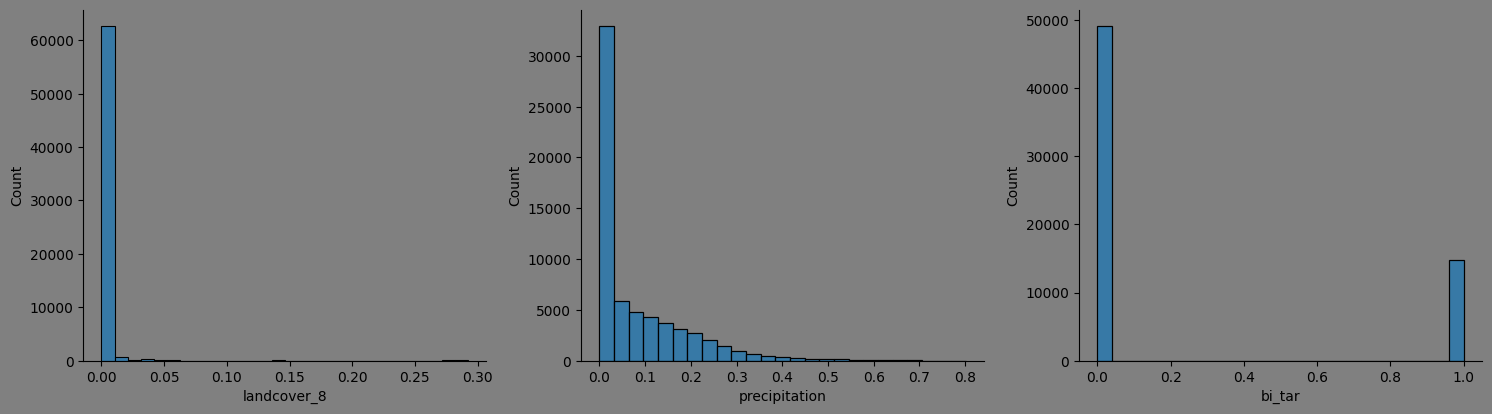

In [ ]:
# feature distribution
dis_cols = list(train.drop(drop_cols + ['day', 'month', 'year'], axis = 1).columns)
itr_plot(train, dis_cols, target, kind = 'h', bins = 'doane')

Observations:
- Existance of severly skewed distributions(i.e: climate_ro, landcovers), including target variable.
- Some features has no variance (climate_swe, landcover_3). Note that landcover_3 appears in 2013 which is a validation year.
- Features are on different scale

  0%|          | 0/26 [00:00<?, ?it/s]

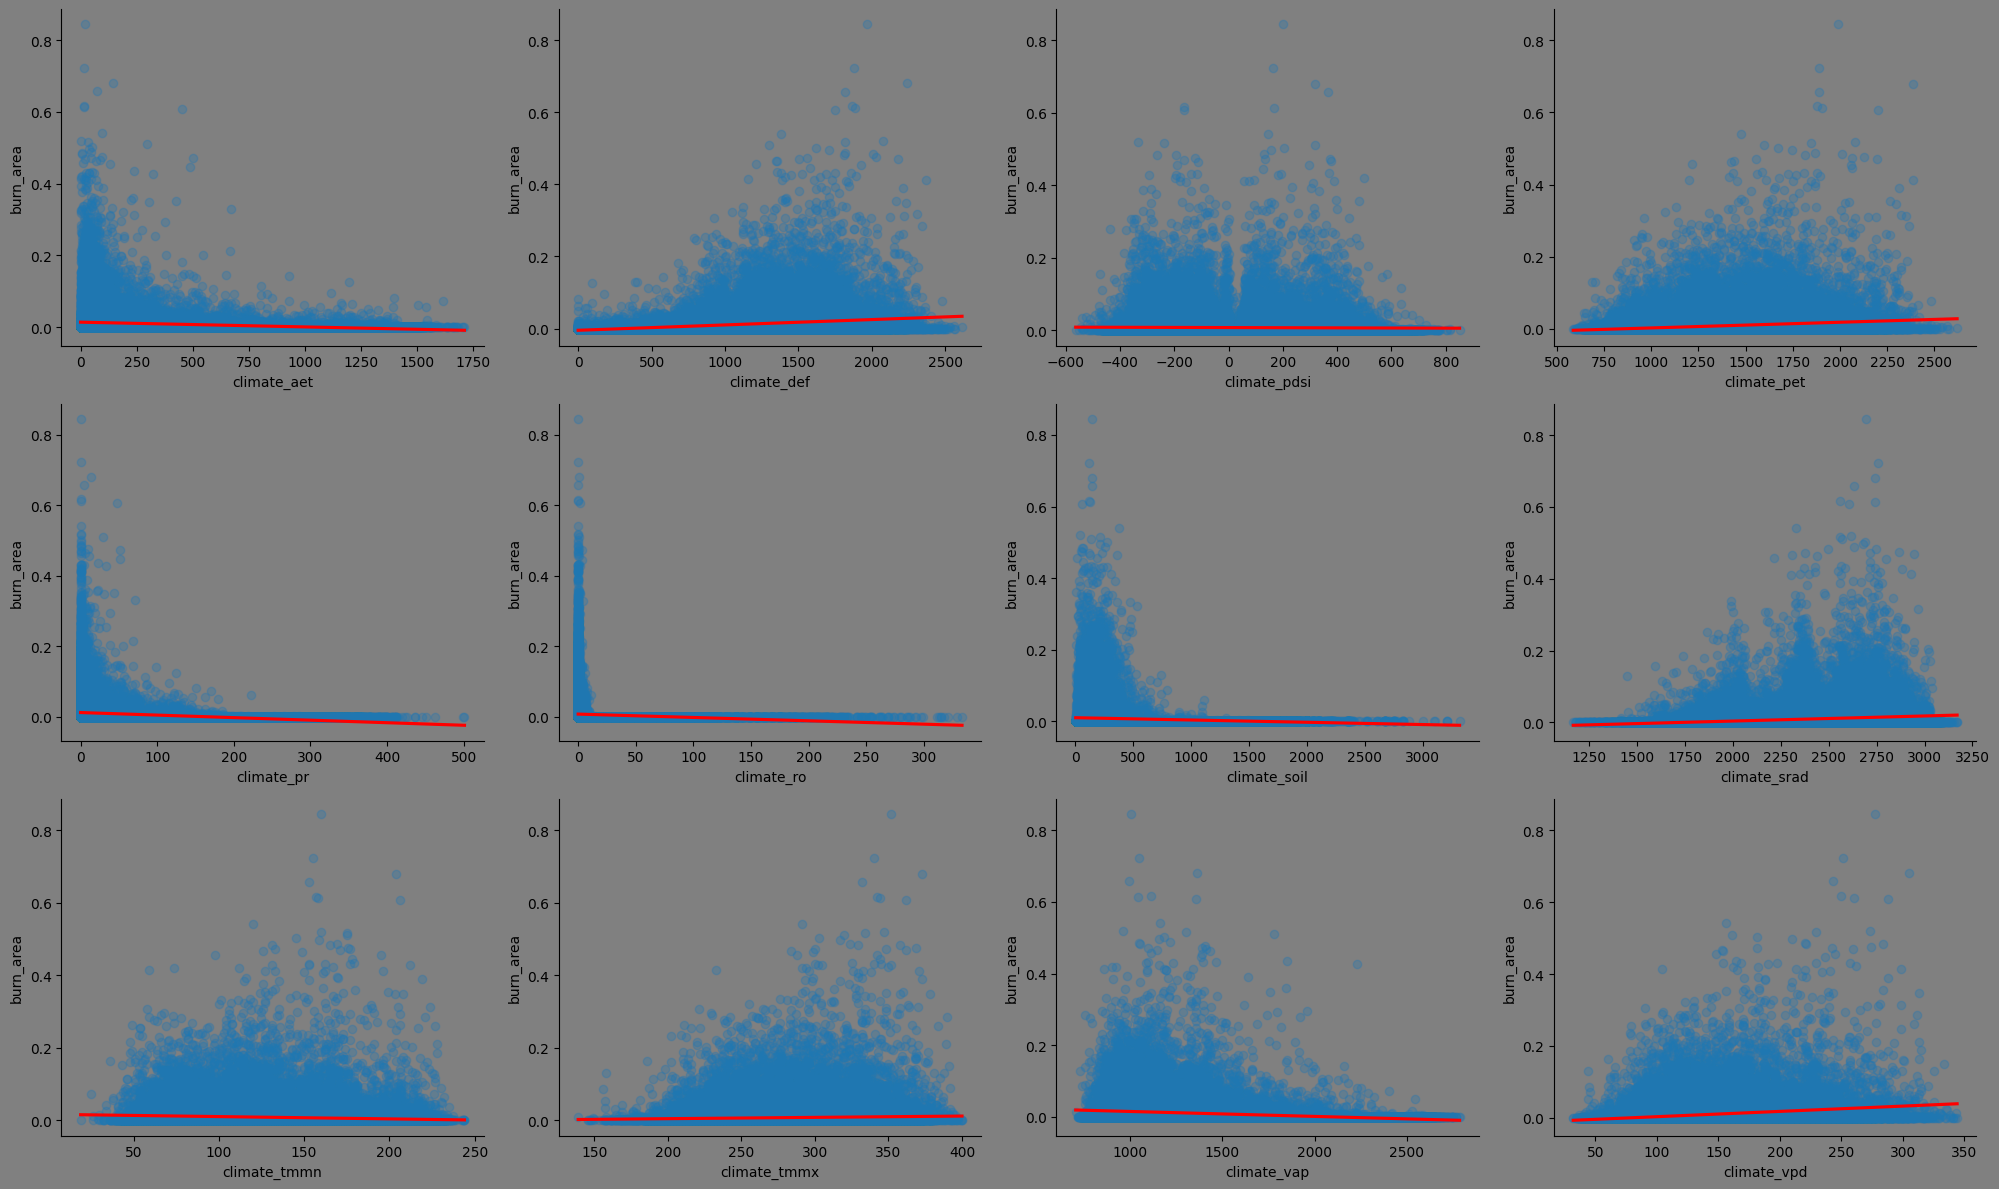

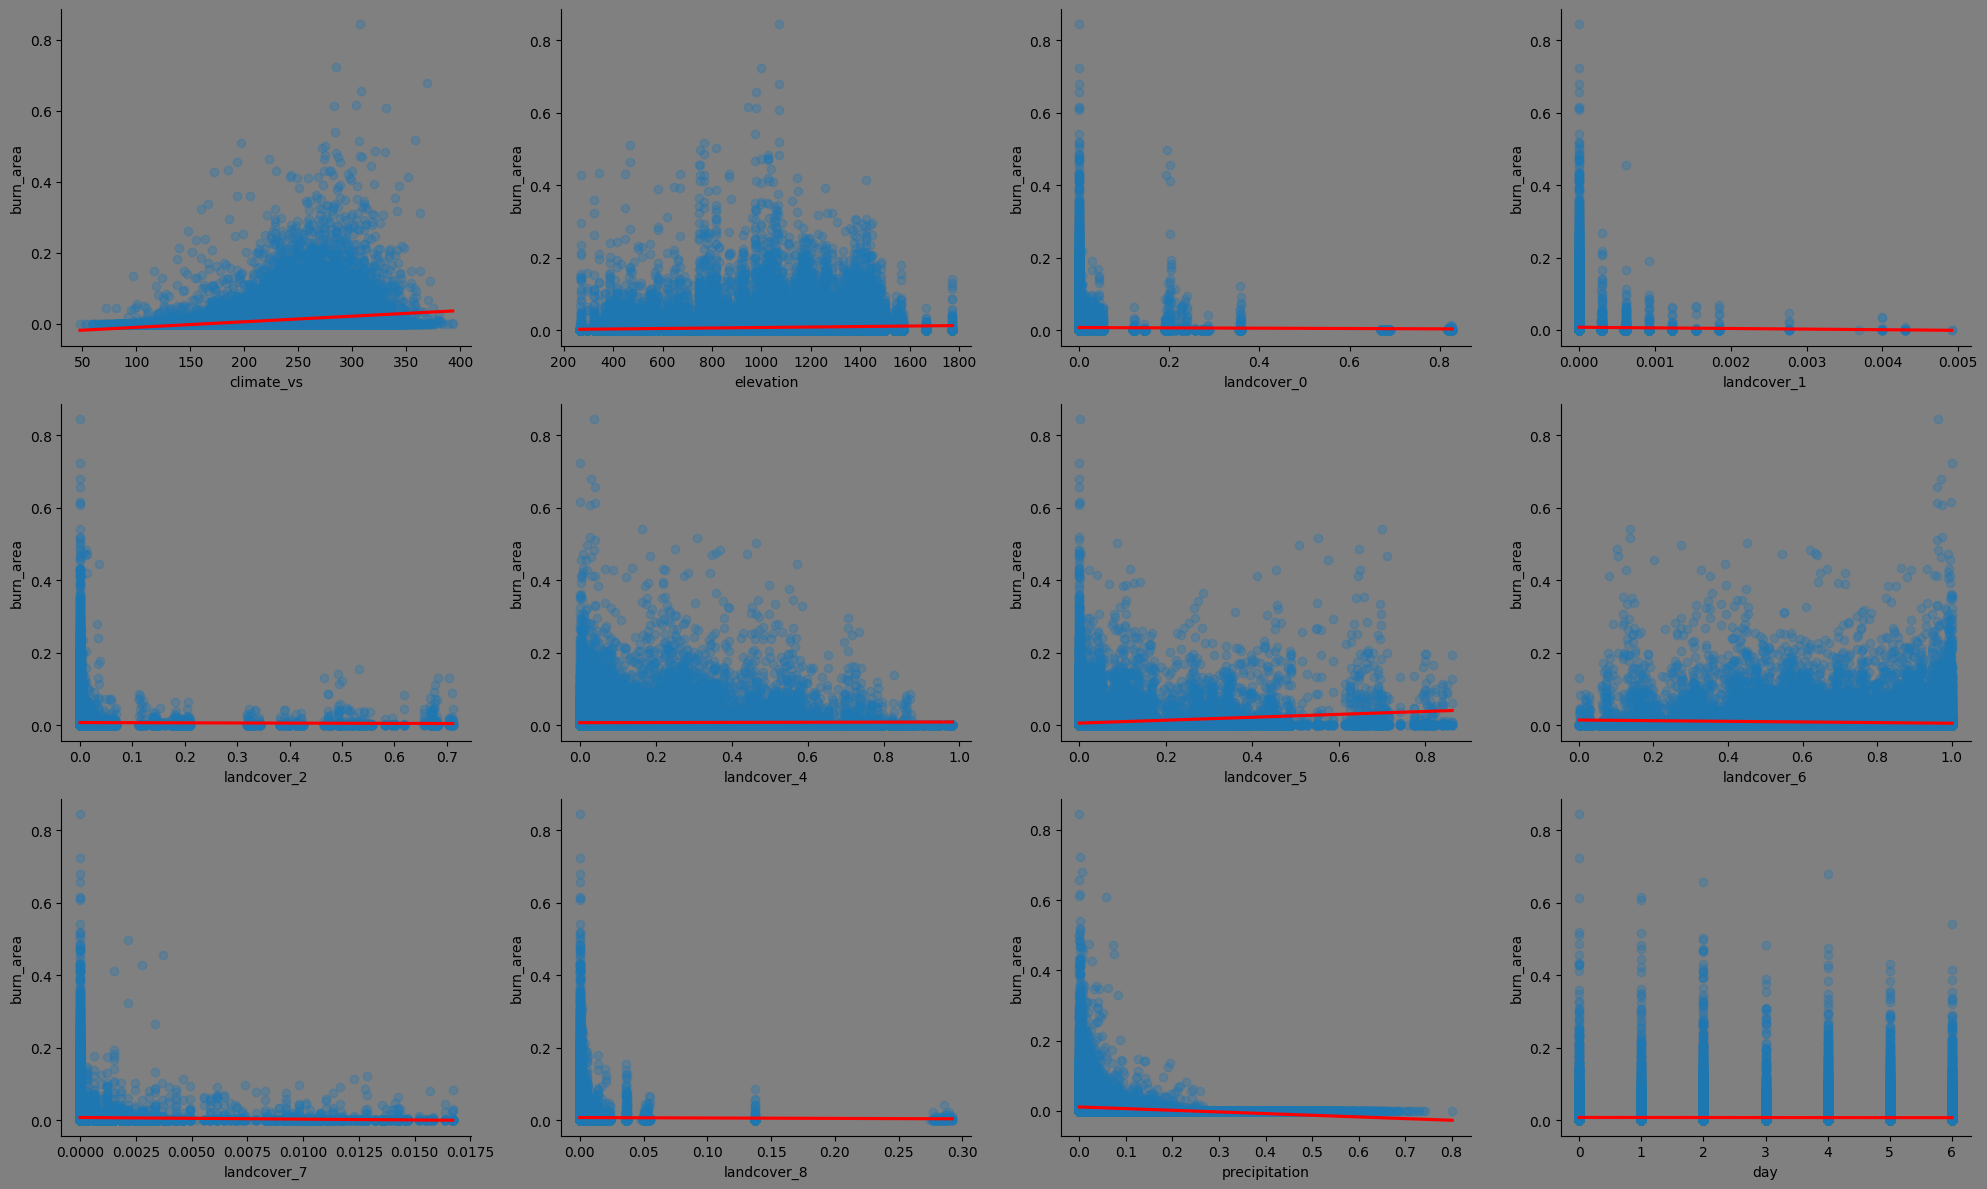

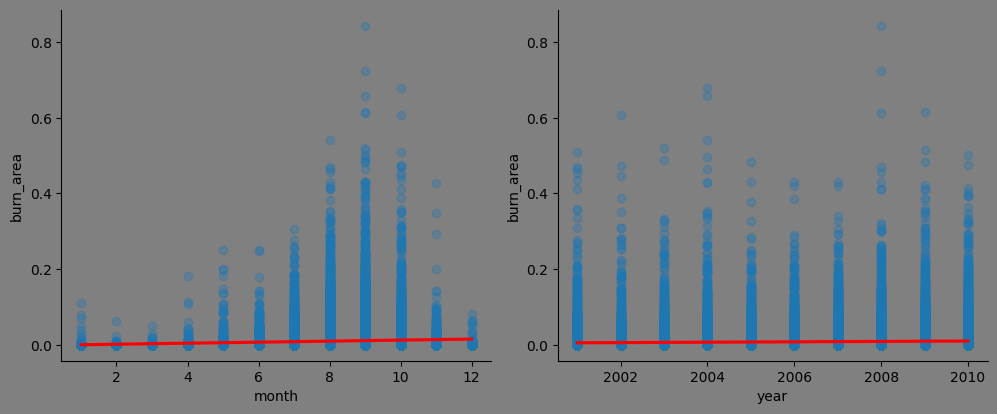

In [ ]:
# trend analysis
execlude = ['burn_area', 'bi_tar', 'climate_swe', 'landcover_3']
t_cols = list(train.drop(drop_cols + execlude, axis = 1).columns)

itr_plot(train, t_cols, target)

Calculating Corr....:   0%|          | 0/26 [00:00<?, ?it/s]

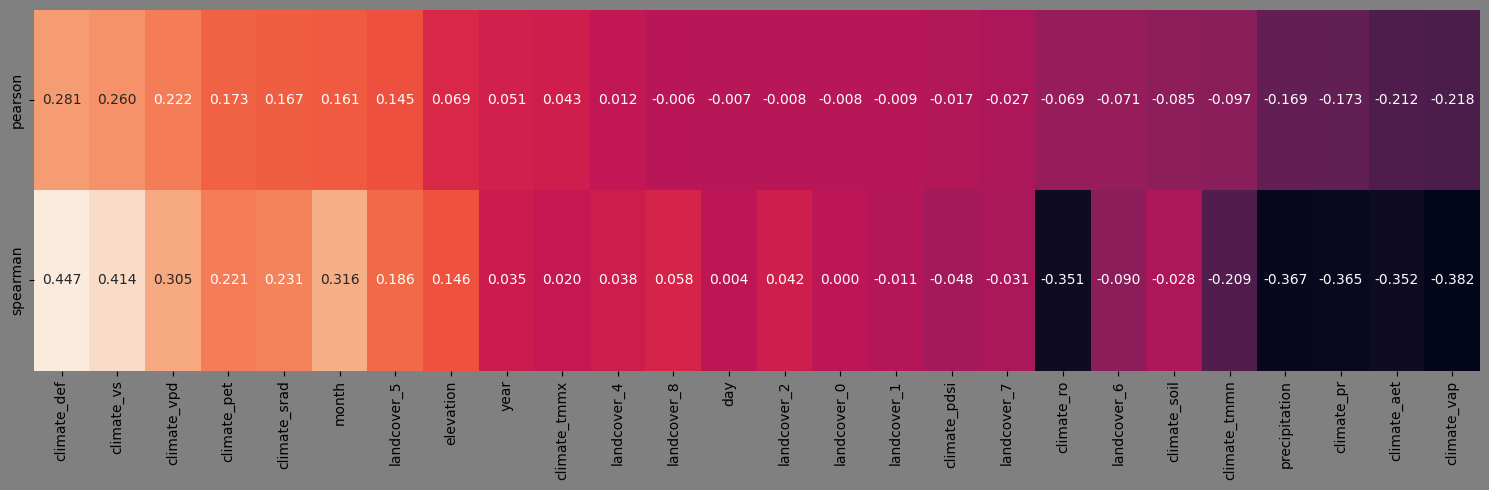

In [ ]:
# correlation analysis
corr, feat_corr = corr_check(t_cols, train, target)

# sorted by pearson coef
fig = plt.figure(figsize=(15,5))
sns.heatmap(
            corr.T.loc[['pearson', 'spearman']].dropna(),
            annot = True,
            fmt = '.3f',
            annot_kws = {'size': 10},
            cbar = False,
);

Observations:
- Absense of strong linear relationships given the trends analysis and size of spearman correlation coef compared to pearsons.

In [ ]:
# burn area - overview - training data
ovrlall_df_tr = train.groupby(['Id', 'lon', 'lat'], as_index = False)['burn_area'].mean()

fig = px.scatter(ovrlall_df_tr, x = 'lon', y = 'lat', color = 'burn_area',
                 hover_data = {'Id': True, 'burn_area':':.4f'},
                 template = 'plotly_dark')

fig.show()

In [ ]:
# burn area - overview - validation data
ovrlall_df_ts = valid.groupby(['Id', 'lon', 'lat'], as_index = False)['burn_area'].mean()

fig = px.scatter(ovrlall_df_ts, x = 'lon', y = 'lat', color = 'burn_area',
                 hover_data = {'Id': True, 'burn_area':':.4f'},
                 template = 'plotly_dark')

fig.show()

As noted earlier hight burn area remains consistent overtime, additionally, some regions do not experience fire incedents. Maybe distance feature between each area could be good predictor, however, the problem is that we have 533 area that means 533^2 features!

In order to control the number of distance features I'll do the following:
- Calculate overall distance from selected areas where selection can be arbitiary, based on highest burn areas or mix.

- Using the plot grid as a guide for segmenting group of areas and calculating distance from the highest and lowest burn area within the segment. Example: areas within lat(-17, -16) and lon(29, 30) act as a segment within which to calculated distance between each area and the highest(Id: 16) and lowest(Id: 9).

**<a href="#toc" style='color:#00ffff'>Table of contents</a>**

<a id='mfe'></a>

## Modeling and Feature Engineering

### Overall objective and expected model behavior
My goal is to build a model that captures the signals from repetitive temporal, interactions and proximity features.

### Modeling Overview:
Running progressive 4 fold validation, re-training the model with each year addition and feature engineering within fold. `RMSE` will be calculated per fold and final evaluation will be based on Last fold score as it is most representative given full training data. Its expected to have a decreasing score per fold.

### Modeling steps - per fold:
- Feature Engineering:
  - This includes experimenting with different combination of features and models, Experimenting included:
    - Temporal features: given the fact that fire incidents peaks and repeats during specific months
    - Features that capture change over time: this has been tested across all zones and within zones during the full training period and year on year. Examples: rolling mean, std, var, cov and z-scores using different rolling windows specially those near peak months.
    - Feature interaction, ranges and ratios: for example, elevation multiply wind speed, Vapor pressure deficit divided Vapor pressure, max temperature - min temperature and so on.
    - Feature grouping: grouping features then calculating dispersion and interaction statistics within groups. Grouping is done based on my understanding of what each feature represents and also experimenting with different group combinations. This has also been inspired by this paper [Meteorological Drought: Palmer](https://www.droughtmanagement.info/literature/USWB_Meteorological_Drought_1965.pdf)
    - Discretization of continuous features using decision trees followed by optional encoding, when a decision tree makes a prediction, it assigns an observation to one of N end leaves, therefore, any decision tree will generate a discrete output, this creates a monotonic relationship with target variable. The choice of reordering the discretized interval using Ordinal encoding instead of OHE to control the size of feature subset, existence of meaningful ordinal relationship (i.e.: temperature - high, low) and the fact that I'll be using tree based models which can handle ordinal values as split points.
    - Performing winsorization, capping feature values at specific values, these values can be parametric(z-scores) or non-parametric(IQR, MAD, quantiles)
    - Target encoding followed by binning, the coise of bins was based on sqrt(N) where N is number of areas. This is a sort of clustering area based on historical burn records and it did actually improve model performance.
    - Calculating distance(haversine) between each area using Lat and Long, the challenge was to select specific reference areas from which to calculate distance between all other areas. Initial choice was to use high burn areas as reference ones but segmenting all areas and calculating distance between highest and lowest burn area within the segment did provide better results same as converting distance from KM to Miles. Segmentation is done as discussed in EDA section.
    - Calculating year on year change in land cover, using 2001 as reference year.
    - Scaling all features: My initial thought was to perform Power Transformation or MinMax Scaling but normalizing selected features to zero mean and unit variance using StandardScaler did provide better  results
    - Target transformation: the only transformation that did improve performance given this feature set was log(1 + `burn_area`) as it is full of zeros. The choice of transformation was to unmask linear relationships between the features and target.

- Rational behind model selection:
  - Using gradient boosting framework that relies on models that are robust to skewed distributions and absence of non-linear trends
  - limiting initial hyper parameter optimization in favor of later voting; Fine tuning the final best candidate models
  - Once an initial model is selected, additional models will be added to form a voting ensemble meta-estimator that fits all base models, each on the whole dataset, then averaging the individual predictions to form a final prediction.
  - Using `lgb` as base model as it provided best initial results in terms of `rmse` and training speed; emphasis is placed on memory usage and training speed to trial with different feature subsets and transformations.
  - Additional models added to the voting estimator are `ExtraTreesRegressor`, `KNeighborsRegressor`, `HistGradientBoostingRegressor`, `BaggingRegressor` with base `ExtraTreeRegressor` estimator. The choice of these models was based initially on improved prediction results without Fine Tuning and latter on the final results after Fine Tuning
  - Fine tuning each individual estimator was done manually and sequentially, this means tuning hyperparameter of first model in the pipeline, assessing prediction results in terms of reduction in `RMSE` and then moving to next model.
  - Choice of hyperparameters to tune is mainly confined to the structure(depth, leaf nodes), size(number of boosting trees, number of features used) and gradient optimization of loss function(learning rate)
  - Fixed seed was used for all estimators to ensure consistency of results
- Run time (including training and prediction):
  - `lgb` 4 fold validation without feature engineering: ~1 second per fold
  - `lgb` 4 fold validation with feature engineering: ~4 seconds per fold
  - `Voting Regressor` 4 fold validation with feature engineering: ~34 seconds per fold
  - `Voting Regressor` on full training data for final submission with feature engineering: ~50 seconds

- Setting thresholds:
  - Predictions are clipped to be in the range of 0 and 1, thus negative predictions are eliminated. This is reflected in the `rmse` reported per each validation fold
  - Predictions are set to nil for areas showing consistent zero burn during last three training years(i.e: area ID 1). This is reflected in final model predictions and submission. The rationale behind this step is the limited availability of external data and that current features does not adequately represent these areas; This has minor effect on reduction of overall `rmse`.
  

In [ ]:
# list all features
train.columns

Index(['ID', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'Id', 'Date', 'day', 'month', 'year',
       'bi_tar'],
      dtype='object')

In [ ]:
# Example of testing new features
mask = train[train.Id.isin([0,1])].copy()
mask['test_feature'] = mask['climate_vpd'] / mask['climate_vap']
plot_cols = ['test_feature', 'climate_vap', 'climate_vpd' ,'burn_area']

# scale for plotting
scaler = StandardScaler()
mask_scaled_a0 = pd.DataFrame(scaler.fit_transform(mask[mask.Id == 0][plot_cols]), columns = plot_cols)
mask_scaled_a1 = pd.DataFrame(scaler.fit_transform(mask[mask.Id == 1][plot_cols]), columns = plot_cols)

mask_scaled_a0.index = mask[mask.Id == 0].Date
mask_scaled_a0['Id'] = 0
mask_scaled_a1.index = mask[mask.Id == 1].Date
mask_scaled_a1['Id'] = 1

mask_scaled = pd.concat([mask_scaled_a0, mask_scaled_a1])

# plot
fig = px.line(mask_scaled, y = plot_cols , facet_row = 'Id', title = 'feature comparison - areawise', template = 'plotly_dark')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Not all areas are affected equally with feature fluctuation, area_1 and the like will be challanging to estimate.

In [ ]:
# feature engineering listings


# basic features
feat_bs = ['lat', 'lon', 'climate_aet', 'climate_def',
           'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
           'climate_soil', 'climate_srad', 'climate_tmmn',
           'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
           'landcover_0', 'landcover_1', 'landcover_2',
           'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
           'landcover_8', 'precipitation', 'Id', 'day', 'month']

# usefull cols
cols = ['climate_aet', 'climate_def',
        'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
        'climate_soil', 'climate_srad', 'climate_tmmn',
        'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation', 'precipitation']

# grouping features
gs = {
    'eva_gs':['climate_aet',  'climate_pet', 'climate_vs', 'elevation',],
    'vap_gs':['climate_vap', 'climate_vpd', 'climate_def'],
    'temp_gs':['climate_tmmn', 'climate_tmmx', 'climate_vap', 'climate_vpd','climate_vs', 'elevation', ],
    'percp_gs':['climate_pr', 'precipitation', 'climate_ro', 'climate_vs', 'elevation',],
    'soil_gs':['climate_pdsi', 'climate_soil', 'climate_vap', 'climate_vpd',],
    'eva2_gs':['climate_aet', 'climate_def', 'climate_pet', 'climate_pr', ],
    'vap2_gs':['climate_vap', 'climate_vpd',  'climate_tmmn', 'climate_tmmx', 'climate_pr',],
    'soil_gs':['climate_vap', 'climate_vpd',  'climate_tmmn', 'climate_tmmx', 'climate_pr','climate_soil',
               'climate_pdsi', 'climate_def'],
     }

# land features
landuse = [
    'landcover_2', 'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7', 'landcover_8'
]

# rolling columns
roll_cols = ['climate_srad']

# target encode columns
tarenc_cols = ['Id']

# final feature set that returned best results during model(s) comparison, tuning and evaluation
# these are basic + new features, distance features gets added during cross validation loop
feat_fe = [
       'lat', 'lon', 'climate_aet', 'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_tmmn', 'climate_tmmx', 'climate_vap', 'climate_vpd',
       'climate_vs', 'elevation', 'landuse_2', 'landuse_4', 'landuse_5', 'landuse_6', 'landuse_7', 'landuse_8',
       'precipitation', 'Id', 'day', 'month', 'vpd_div_vap', 'ele_mul_vs', 'def_div_aet', 'srad_mul_pet', 'climate_tmmx_diff', 'max(vap_gs)'
]

In [ ]:
%%time
# progressive validation
fold_split = {1:2008, 2:2009, 3:2010, 4:2011}

# basline model with basic features
results_base, model_base, preds_base = cross_val(train, valid, feat_bs, 'burn_area', fold_split)

results_base

Ongoing Validation.....:   0%|          | 0/4 [00:00<?, ?it/s]

fold_1:  train_years: 2001 to 2007 test_years: 2011 to 2013
fold_2:  train_years: 2001 to 2008 test_years: 2011 to 2013
fold_3:  train_years: 2001 to 2009 test_years: 2011 to 2013
fold_4:  train_years: 2001 to 2010 test_years: 2011 to 2013
CPU times: user 4.83 s, sys: 95.5 ms, total: 4.93 s
Wall time: 4.97 s


,f_1,f_2,f_3,f_4,avg
mse,0.000522,0.000518,0.000515,0.000506,0.000515
rmse,0.022853,0.022753,0.022701,0.022490,0.022699
r2,0.377930,0.383343,0.386178,0.397519,0.386242


with the addition of new year data, score is imporved a little bit

In [ ]:
# Model Architecture
model_base

Pipeline(steps=[('Scalar', StandardScaler()),
                ('LGBM', LGBMRegressor(random_state=45, verbose=-1))])

In [ ]:
%%time
# Feature Engineering - single model
results_fe, model_fe, preds_fe = cross_val(train, valid, feat_fe, 'burn_area', fold_split,
                                           fe = True, change_cols = cols, grouping_cols = gs,
                                           landuse_cols = landuse, rolling_cols = roll_cols,
                                           roll_d = {col: dict(agg = 'std', w = 7) for col in roll_cols},
                                           te_cols = tarenc_cols,
                                          )

results_fe

Ongoing Validation.....:   0%|          | 0/4 [00:00<?, ?it/s]

fold_1:  train_years: 2001 to 2007 test_years: 2011 to 2013
fold_2:  train_years: 2001 to 2008 test_years: 2011 to 2013
fold_3:  train_years: 2001 to 2009 test_years: 2011 to 2013
fold_4:  train_years: 2001 to 2010 test_years: 2011 to 2013
CPU times: user 16.4 s, sys: 778 ms, total: 17.2 s
Wall time: 17.4 s


,f_1,f_2,f_3,f_4,avg
mse,0.000485,0.000480,0.000476,0.000448,0.000472
rmse,0.022033,0.021910,0.021818,0.021168,0.021732
r2,0.421765,0.428218,0.432978,0.466283,0.437311


New features did improve predictions, decent reduction in rmse across the folds

In [ ]:
# Model Architecture
model_fe

Pipeline(steps=[('Scalar', StandardScaler()),
                ('LGBM', LGBMRegressor(random_state=45, verbose=-1))])

In [ ]:
# plot feature importance
fi_df = pd.DataFrame(list(zip(model_fe.feature_names_in_, model_fe[1].feature_importances_)), columns = ['feat', 'score'])
top_feats = fi_df[fi_df.score > 0].sort_values('score', ascending = False)
fig = px.bar(top_feats, x = 'score', y = 'feat', orientation = 'h', template = 'plotly_dark')
fig.show()

Feature importance matches the signals we picked up during EDA, in addition the model do utilize distance and area details (Id, lat, long) in making prediction given the repetitve nature of fire incidents noticed earlier.

In [ ]:
%%time
# Feature Engineering - voting model
results_v, model_v, preds_v = cross_val(train, valid, feat_fe, 'burn_area', fold_split,
                                        fe = True, change_cols = cols, grouping_cols = gs,
                                        landuse_cols = landuse, rolling_cols = roll_cols,
                                        roll_d = {col: dict(agg = 'std', w = 7) for col in roll_cols},
                                        te_cols = tarenc_cols, voting = True,
                                        )
results_v

Ongoing Validation.....:   0%|          | 0/4 [00:00<?, ?it/s]

fold_1:  train_years: 2001 to 2007 test_years: 2011 to 2013
fold_2:  train_years: 2001 to 2008 test_years: 2011 to 2013
fold_3:  train_years: 2001 to 2009 test_years: 2011 to 2013
fold_4:  train_years: 2001 to 2010 test_years: 2011 to 2013
CPU times: user 1min 3s, sys: 2.89 s, total: 1min 6s
Wall time: 2min 11s


,f_1,f_2,f_3,f_4,avg
mse,0.000472,0.000465,0.000458,0.000432,0.000457
rmse,0.021731,0.021568,0.021400,0.020775,0.021369
r2,0.437534,0.445913,0.454495,0.485908,0.455963


In [ ]:
# Model Architecture
model_v

Pipeline(steps=[('Scalar', StandardScaler()),
                ('Voting Regressor',
                 VotingRegressor(estimators=[('lgbm',
                                              LGBMRegressor(n_estimators=300,
                                                            random_state=45)),
                                             ('et',
                                              ExtraTreesRegressor(max_depth=50,
                                                                  max_features='log2',
                                                                  n_estimators=40,
                                                                  random_state=45)),
                                             ('knn',
                                              KNeighborsRegressor(algorithm='brute',
                                                                  n_neighbors=6)),
                                             ('hg',
                                              HistGradientBoostingRegressor(l2_regularization=0.05,
                                                                            max_iter=450,
                                                                            max_leaf_nodes=21,
                                                                            random_state=45)),
                                             ('bag',
                                              BaggingRegressor(estimator=ExtraTreeRegressor(max_features='sqrt',
                                                                                            random_state=45),
                                                               max_features=0.6,
                                                               random_state=45))],
                                 n_jobs=-1))])

In [ ]:
# prediction comparison plot
pred_df = pd.concat([valid[['Date', 'Id', target]],
                     pd.Series(preds_fe, index = valid[target].index, name = 'Single_preds'),
                     pd.Series(preds_v, index = valid[target].index, name = 'Voting_preds')
                    ], axis = 1)

fig = px.line(pred_df[pred_df.Id == 1], x = 'Date', y = pred_df.columns[2:],
              title = f'Prediction Comparison', template = 'plotly_dark')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Given the repetitive nature of fire incidents, I'll use historical data of past 3 years from the training set(validation set will be training set for final model) and change predictions of areas having no incidents during these years to nil.

In [ ]:
# remove predictions based of consistent no burn area
area_d = (pred_df.groupby(['Id'])['burn_area'].mean() == 0).to_dict()
no_burn_list = [id for id in area_d.keys() if area_d[id]]
pred_df.loc[pred_df.Id.isin(no_burn_list), 'Voting_preds'] = 0 # adjust voting preds

print(f"adjusted RMSE: {round(np.sqrt(mean_squared_error(valid[target], pred_df['Voting_preds'])), 6)}")

fig = px.line(pred_df[pred_df.Id == 1], x = 'Date', y = pred_df.columns[2:],
              title = f'Prediction Comparison', template = 'plotly_dark')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



adjusted RMSE: 0.020742


In [ ]:
%%time
# fit on full data
# no validation taking place
# just utilizing the cv function

fold_split = {1:2014} # <<--- full range of years in training + validation data i.e: 2013
model_v_sub, preds_v_sub = cross_val(df_tr, df_ts, feat_fe, 'burn_area', fold_split,
                                     fe = True, change_cols = cols, grouping_cols = gs,
                                     landuse_cols = landuse, rolling_cols = roll_cols,
                                     roll_d = {col: dict(agg = 'std', w = 7) for col in roll_cols},
                                     te_cols = tarenc_cols, voting = True, sub = True)

Ongoing Validation.....:   0%|          | 0/1 [00:00<?, ?it/s]

fold_1:  train_years: 2001 to 2013 test_years: 2014 to 2017
CPU times: user 28.7 s, sys: 1.11 s, total: 29.9 s
Wall time: 50.1 s


In [ ]:
# Model Architecture
model_v_sub

Pipeline(steps=[('Scalar', StandardScaler()),
                ('Voting Regressor',
                 VotingRegressor(estimators=[('lgbm',
                                              LGBMRegressor(n_estimators=300,
                                                            random_state=45)),
                                             ('et',
                                              ExtraTreesRegressor(max_depth=50,
                                                                  max_features='log2',
                                                                  n_estimators=40,
                                                                  random_state=45)),
                                             ('knn',
                                              KNeighborsRegressor(algorithm='brute',
                                                                  n_neighbors=6)),
                                             ('hg',
                                              HistGradientBoostingRegressor(l2_regularization=0.05,
                                                                            max_iter=450,
                                                                            max_leaf_nodes=21,
                                                                            random_state=45)),
                                             ('bag',
                                              BaggingRegressor(estimator=ExtraTreeRegressor(max_features='sqrt',
                                                                                            random_state=45),
                                                               max_features=0.6,
                                                               random_state=45))],
                                 n_jobs=-1))])

In [ ]:
# final feature set
model_v_sub.feature_names_in_

array(['lat', 'lon', 'climate_aet', 'climate_pdsi', 'climate_pet',
       'climate_pr', 'climate_ro', 'climate_soil', 'climate_srad',
       'climate_tmmn', 'climate_tmmx', 'climate_vap', 'climate_vpd',
       'climate_vs', 'elevation', 'landuse_2', 'landuse_4', 'landuse_5',
       'landuse_6', 'landuse_7', 'landuse_8', 'precipitation', 'Id',
       'day', 'month', 'vpd_div_vap', 'ele_mul_vs', 'def_div_aet',
       'srad_mul_pet', 'climate_tmmx_diff', 'max(vap_gs)', 'dist_2',
       'dist_3', 'dist_4', 'dist_16', 'dist_6', 'dist_20', 'dist_21',
       'dist_5', 'dist_15', 'dist_37', 'dist_26', 'dist_42', 'dist_41',
       'dist_141', 'dist_71', 'dist_119', 'dist_118', 'dist_65',
       'dist_111', 'dist_146', 'dist_76', 'dist_150', 'dist_80',
       'dist_132', 'dist_130', 'dist_128', 'dist_197', 'dist_170',
       'dist_203', 'dist_233', 'dist_164', 'dist_179', 'dist_234',
       'dist_211', 'dist_210', 'dist_247', 'dist_189', 'dist_153',
       'dist_184', 'dist_215', 'dist_158', 'di

In [ ]:
# submission
sub_df = df_ts[['ID']].copy()
sub_df['burn_area'] = preds_v_sub # <----cliped
sub_df.to_csv('sub_df_v.csv', index = False)

# trimed
sub_df_trim = df_ts[['ID', 'Id']].copy()
sub_df_trim['burn_area'] = preds_v_sub
sub_df_trim.loc[sub_df_trim.Id.isin(no_burn_list), 'burn_area'] = 0 # adjust based on validation set
del sub_df_trim['Id']
sub_df_trim.to_csv('sub_df_v_trim.csv', index = False)

display(sub_df, sub_df_trim)

,ID,burn_area
0,0_2014-01-01,0.002276
1,1_2014-01-01,0.000302
2,2_2014-01-01,0.000304
3,3_2014-01-01,0.000000
4,4_2014-01-01,0.000000
...,...,...
25579,528_2017-12-01,0.000187
25580,529_2017-12-01,0.004797
25581,530_2017-12-01,0.003512
25582,531_2017-12-01,0.004668


,ID,burn_area
0,0_2014-01-01,0.002276
1,1_2014-01-01,0.000000
2,2_2014-01-01,0.000000
3,3_2014-01-01,0.000000
4,4_2014-01-01,0.000000
...,...,...
25579,528_2017-12-01,0.000000
25580,529_2017-12-01,0.000000
25581,530_2017-12-01,0.003512
25582,531_2017-12-01,0.004668


**<a href="#toc" style='color:#00ffff'>Table of contents</a>**